# Описание проекта

Вы - маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несколько прошлых месяцев ваш бизнес постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого. Вам нужно разобраться в причинах этой ситуации.

У вас в распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Вам предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отрицательно влияют на привлечение пользователей.

#### **Описание данных**

Таблица `visits_log_short` (лог сервера с информацией о посещениях сайта):
- `User Id` — уникальный идентификатор пользователя
- `Device` — категория устройства пользователя
- `Session start` — дата и время начала сессии
- `Session End` — дата и время окончания сессии
- `Channel` — идентификатор рекламного источника, из которого пришел пользователь
- `Region` - страна пользователя

Таблица `orders_log_short` (информация о заказах):
- `User Id` — уникальный id пользователя, который сделал заказ
- `Event Dt` — дата и время покупки
- `Revenue` — выручка

Таблица `costs_short` (информация о затратах на маркетинг):
- `Channel` — идентификатор рекламного источника
- `Dt` — дата
- `Costs` — затраты на этот рекламный источник в этот день

## Шаг 1. Загрузим данные и подготовим их к анализу

In [1]:
# подключим необходимые библиотеки и настройки графики

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

pd.set_option('display.float_format', '{:.3f}'.format)


%config InlineBackend.figure_format = 'retina'
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# сохраним данные о визитах, заказах и расходах в переменные 

visits = pd.read_csv('https://code.s3.yandex.net/datasets/visits_info_short.csv')
orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders_info_short.csv') 
costs = pd.read_csv('https://code.s3.yandex.net/datasets/costs_info_short.csv')

In [3]:
# смотрим информацию о датасете visits

visits.info()
visits.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40

In [4]:
# смотрим информацию о датасете orders

orders.info()
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52    4.990
1  174361394180  2019-05-01 12:24:04    4.990
2  529610067795  2019-05-01 11:34:04    4.990
3  319939546352  2019-05-01 15:34:40    4.990
4  366000285810  2019-05-01 13:59:51    4.990

In [5]:
# смотрим информацию о датасете orders

costs.info()
costs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


dt   Channel   costs
0  2019-05-01  FaceBoom 113.300
1  2019-05-02  FaceBoom  78.100
2  2019-05-03  FaceBoom  85.800
3  2019-05-04  FaceBoom 136.400
4  2019-05-05  FaceBoom 122.100

Похоже, что данные в порядке – пропущенных значений не обнаружено.

Нужно попроваить стилистические недочеты в названиях столбцов и привести столбцы о времени к корректному типу данных.

In [6]:
# приведем названия столбцов к snake_case

df_list = [visits, orders, costs]
for i, df in enumerate(df_list, 1):
    df.columns = [col_name.lower().replace(' ', '_') for col_name in df.columns]

In [7]:
# преобразуем данные о времени для дальнейших расчётов

visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date


## Шаг 2. Зададим функции для расчета и анализа LTV, ROI, удержания и конверсии, а также для визуализации результатов

### Функция для создания пользовательских профилей

In [8]:
# функция для создания профилей пользователей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

### Функция для расчета LTV и ROI

In [9]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

### Функция для расчета Retention rate (удержания)

In [10]:
# функция для расчёта retention rate

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### Функция для расчета CR (конверсии)

In [11]:
# функция для расчёта CR

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### Функции для визуализации

In [12]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [13]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [14]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [15]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Момент и горизонт анализа из условия

In [16]:
# задаём момент и горизонт анализа данных
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14

# создаём опцию «игнорировать горизонт»
ignore_horizon = False

In [17]:
# рассчитываем максимально возможную дату привлечения
last_suitable_acquisition_date = observation_date
if not ignore_horizon:
    last_suitable_acquisition_date = observation_date - timedelta(
        days=horizon_days - 1
    )

last_suitable_acquisition_date

datetime.date(2019, 10, 19)

## Шаг 3. Проведем исследовательский анализ данных


### 3.1 Построим профили пользователей. 

In [18]:
# получаем профили из функции
profiles = get_profiles(visits, orders, costs)
profiles

user_id            first_ts       channel  device         region  \
0             599326 2019-05-07 20:58:57      FaceBoom     Mac  United States   
1            4919697 2019-07-09 12:46:07      FaceBoom  iPhone  United States   
2            6085896 2019-10-01 09:58:33       organic  iPhone         France   
3           22593348 2019-08-22 21:35:48    AdNonSense      PC        Germany   
4           31989216 2019-10-02 00:07:44       YRabbit  iPhone  United States   
...              ...                 ...           ...     ...            ...   
150003  999956196527 2019-09-28 08:33:02        TipTop  iPhone  United States   
150004  999975439887 2019-10-21 00:35:17       organic      PC             UK   
150005  999976332130 2019-07-23 02:57:06        TipTop  iPhone  United States   
150006  999979924135 2019-09-28 21:28:09  MediaTornado      PC  United States   
150007  999999563947 2019-10-18 19:57:25       organic  iPhone  United States   

                dt      month  payer  acquisition_cost  
0       2019-05-07 2019-05-01   True             1.088  
1       2019-07-09 2019-07-01  False             1.107  
2       2019-10-01 2019-10-01  False             0.000  
3       2019-08-22 2019-08-01  False             0.988  
4       2019-10-02 2019-10-01  False             0.231  
...            ...        ...    ...               ...  
150003  2019-09-28 2019-09-01  False             3.500  
150004  2019-10-21 2019-10-01  False             0.000  
150005  2019-07-23 2019-07-01  False             2.600  
150006  2019-09-28 2019-09-01  False             0.206  
150007  2019-10-18 2019-10-01  False             0.000  

[150008 rows x 9 columns]

Определим минимальную и максимальную дату привлечения пользователей.

In [19]:
# находим максимальную дату привлечения 
max_acquitision_dt = profiles['dt'].max()
min_acquitision_dt = profiles['dt'].min()


# отсекаем профили, которые вне этих дат
ltv_profiles = profiles.query('@min_acquitision_dt <= dt <= @max_acquitision_dt')

ltv_profiles

user_id            first_ts       channel  device         region  \
0             599326 2019-05-07 20:58:57      FaceBoom     Mac  United States   
1            4919697 2019-07-09 12:46:07      FaceBoom  iPhone  United States   
2            6085896 2019-10-01 09:58:33       organic  iPhone         France   
3           22593348 2019-08-22 21:35:48    AdNonSense      PC        Germany   
4           31989216 2019-10-02 00:07:44       YRabbit  iPhone  United States   
...              ...                 ...           ...     ...            ...   
150003  999956196527 2019-09-28 08:33:02        TipTop  iPhone  United States   
150004  999975439887 2019-10-21 00:35:17       organic      PC             UK   
150005  999976332130 2019-07-23 02:57:06        TipTop  iPhone  United States   
150006  999979924135 2019-09-28 21:28:09  MediaTornado      PC  United States   
150007  999999563947 2019-10-18 19:57:25       organic  iPhone  United States   

                dt      month  payer  acquisition_cost  
0       2019-05-07 2019-05-01   True             1.088  
1       2019-07-09 2019-07-01  False             1.107  
2       2019-10-01 2019-10-01  False             0.000  
3       2019-08-22 2019-08-01  False             0.988  
4       2019-10-02 2019-10-01  False             0.231  
...            ...        ...    ...               ...  
150003  2019-09-28 2019-09-01  False             3.500  
150004  2019-10-21 2019-10-01  False             0.000  
150005  2019-07-23 2019-07-01  False             2.600  
150006  2019-09-28 2019-09-01  False             0.206  
150007  2019-10-18 2019-10-01  False             0.000  

[150008 rows x 9 columns]

In [20]:
max_acquitision_dt

datetime.date(2019, 10, 27)

In [21]:
min_acquitision_dt

datetime.date(2019, 5, 1)

В наборе данных рассматриваем промежуток привлечения с 01.05.2019 по 27.10.2019.

### 3.2 Ответим на вопросы исследования:

<div class="alert alert-block alert-info">
<b>Комментарий:</b> 
В задании сказано создавать по одной таблице на каждый вопрос, но мне так не нравится – сложнее увидеть сортировку по сразу двум метрикам. Поэтому я разбила каждый вопрос на 2 разные таблицы-топа – считаю так нагляднее, и это не ошибка.</div>

#### - Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?

In [22]:
# считаем, из каких стран приходят посетители

profiles.groupby('region').agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False)

user_id
region                
United States   100002
UK               17575
France           17450
Germany          14981

In [23]:
# считаем, какие страны в среднем дают больше всего оплат

profiles.groupby('region').agg({'payer' : 'mean'}).sort_values(by='payer', ascending=False)

payer
region              
United States  0.069
Germany        0.041
UK             0.040
France         0.038

Больше всего посетителей приходит из Соединенных Штатов Америки. Там же и самая большая доля платящих пользователей. 

Меньше всего пользователей приходит из Германии, хотя эта страна на 2 месте по доле оплат – можно порекомендовать усилить рекламные кампании в этом регионе.

#### - Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?


In [24]:
# считаем, какими устройствами чаще всего пользуются

profiles.groupby('device').agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False)

user_id
device          
iPhone     54479
Android    35032
PC         30455
Mac        30042

In [25]:
# считаем, с каких устройств чаще всего заходят платящие пользователи

profiles.groupby('device').agg({'payer' : 'mean'}).sort_values(by='payer', ascending=False)

payer
device        
Mac      0.064
iPhone   0.062
Android  0.059
PC       0.050

Больше всего посетителей приходит c устройств iPhone, а меньше всего – с десктопов Mac. 

При этом оплачивают лучше всего пользователи Mac, поэтому можно рекомендовать усилить рекламные кампании для этого типа устройств. Пользователи iPhone тоже платят хорошо, поэтому являются основной когортой, приносящей деньги компании.



#### - По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

In [26]:
# считаем, по каким рекламным каналам шло привлечение пользователей

profiles.groupby('channel').agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False)


user_id
channel                    
organic               56439
FaceBoom              29144
TipTop                19561
OppleCreativeMedia     8605
LeapBob                8553
WahooNetBanner         8553
RocketSuperAds         4448
MediaTornado           4364
YRabbit                4312
AdNonSense             3880
lambdaMediaAds         2149

In [27]:
# считаем, какие каналы приносят больше всего платящих пользователей

profiles.groupby('channel').agg({'payer' : 'mean'}).sort_values(by='payer', ascending=False)

payer
channel                  
FaceBoom            0.122
AdNonSense          0.113
lambdaMediaAds      0.105
TipTop              0.096
RocketSuperAds      0.079
WahooNetBanner      0.053
YRabbit             0.038
MediaTornado        0.036
LeapBob             0.031
OppleCreativeMedia  0.027
organic             0.021

Самая большая доля привлечения пользователей – у органического трафика. В то же время, этот канал приносит меньше всего оплат. Рекомендуется проанализировать поведение пользователей с данного канала, чтобы выяснить причину низкой доли оплат и попытаться скорректировать ожидания от продукта.

При этом выяснилось, что лучше всего платят пользователи, привлеченные каналом FaceBoom. Заметно, что доля привлечения тарфика этим каналом на 2 месте, значит, компания знает об эффективности этого канала и активно размещает там рекламу.

Следует обратить внимание на каналы AdNonSense и lambdaMediaAds – доли платящих пользователей там высокие, но при этом видим мало трафика. 

### Промежуточный вывод:

- Германия на 2 месте по доле оплат, но имеет низкую долю трафика в приложении
- Пользователи платформы Mac имеют самый высокий процент оплат, но низкую долю трафика на момент анализа
- Пользователи, приходящие с бесплатного органического канала привлечения имеют низкую долю оплат – рекомендуется проанализировать поведение этой когорты, чтобы определить точки роста в оплаты
- Рекламные каналы AdNonSense и lambdaMediaAds имеют высокую долю платящих пользователей, но низкий трафик






## Шаг 4. Маркетинг

### 4.1. Посчитаем общую сумму расходов на маркетинг. Выясним, как траты распределены по источникам. Визуализируем изменения метрик во времени.


In [28]:
# считаем сумму расходов на маркетинг

profiles['acquisition_cost'].sum().round()

105497.0

In [29]:
# считаем, ккак расходы распределены по рекламным каналам

profiles.groupby('channel').agg({'acquisition_cost' : 'sum'}).sort_values(by='acquisition_cost', ascending=False)

acquisition_cost
channel                             
TipTop                     54751.300
FaceBoom                   32445.600
WahooNetBanner              5151.000
AdNonSense                  3911.250
OppleCreativeMedia          2151.250
RocketSuperAds              1833.000
LeapBob                     1797.600
lambdaMediaAds              1557.600
MediaTornado                 954.480
YRabbit                      944.220
organic                        0.000

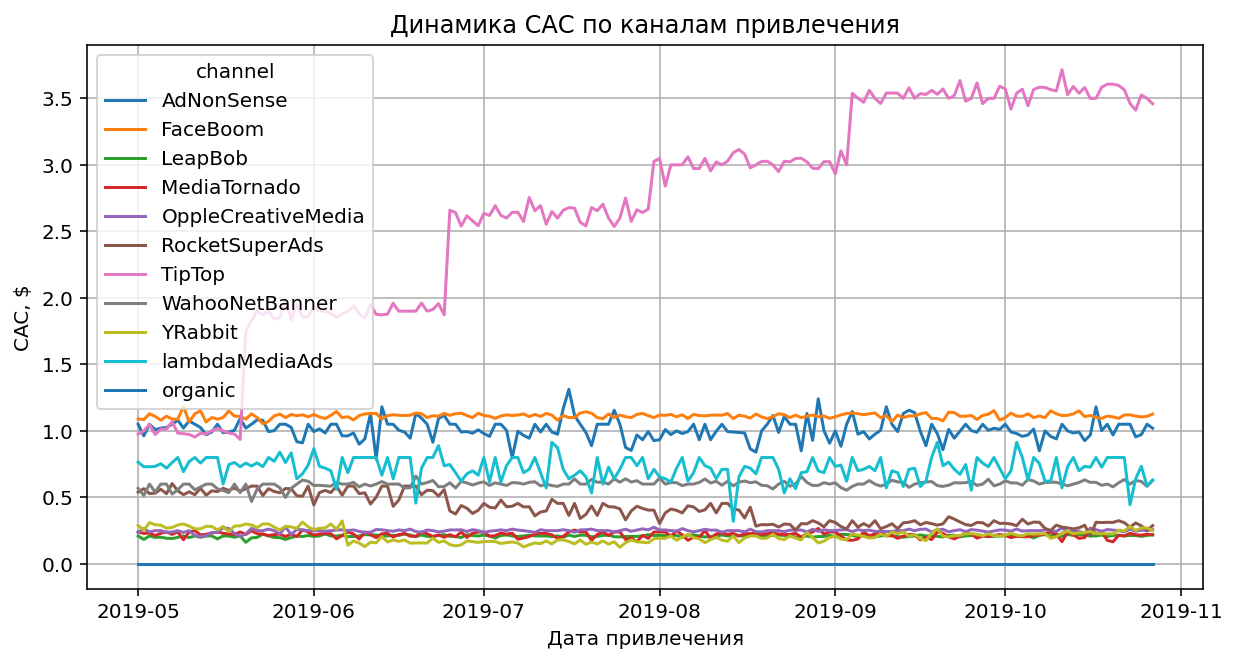

In [30]:
# строим график истории изменений CAC по каналам привлечения

profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(10, 5))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

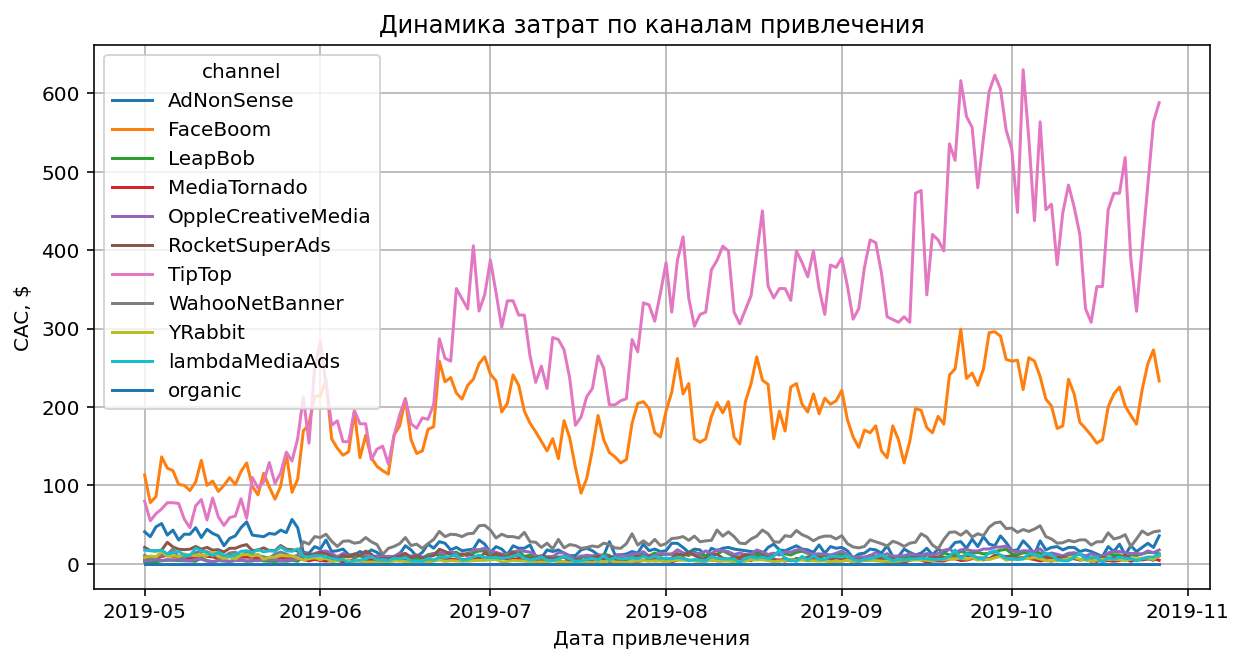

In [31]:
# строим график истории затрат по каналам привлечения

profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='sum'
).plot(grid=True, figsize=(10, 5))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика затрат по каналам привлечения')
plt.show()

По графикам можно сделать такие выводы:

- Выделяется канал TipTop с самым драматичным изменением средней CAC
- Со 2 месяца привлечения маркетинг стал меньше денег вкладывать в канал AdNonSense, зато сильно нарастил расходы по каналам TipTop и FaceBoom

### 4.2. Узнаем, сколько в среднем стоило привлечение одного пользователя из каждого источника. 
Рассчитаем средний CAC на одного пользователя для всего проекта и для каждого источника трафика.


In [32]:
# отфильтруем датасет profiles, оставим только платный трафик

profiles_paid = profiles.query('channel != "organic"')

In [33]:
# считаем средний CAC проекта

profiles_paid['acquisition_cost'].mean().round(3)

1.127

In [34]:
# считаем средний CAC по каналам привлечения

cac = (
    ltv_profiles.groupby('channel')
    .agg({'acquisition_cost': 'mean'})
    .rename(columns={'acquisition_cost': 'cac'})
    .sort_values(by='cac', ascending=False)
)

cac

cac
channel                 
TipTop             2.799
FaceBoom           1.113
AdNonSense         1.008
lambdaMediaAds     0.725
WahooNetBanner     0.602
RocketSuperAds     0.412
OppleCreativeMedia 0.250
YRabbit            0.219
MediaTornado       0.219
LeapBob            0.210
organic            0.000

Промежуточный вывод:

- Больше всего рекламных бюджетов сейчас тратится на каналы TipTop и FaceBoom
- TipTop, FaceBoom и AdNonSense имеют CAC выше среднего значения в 1.127
- Самый дорогой для привлечения канал – это TipTop, он же – самый затратный

## Шаг 5. Оценим окупаемость рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализируем общую окупаемость рекламы;
- Проанализируем окупаемость рекламы с разбивкой по устройствам;
- Проанализируем окупаемость рекламы с разбивкой по странам;
- Проанализируем окупаемость рекламы с разбивкой по рекламным каналам.

Опишем проблемы, которые обнаружили. Ответим на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучим конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

#### Проанализируем общую окупаемость рекламы

Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

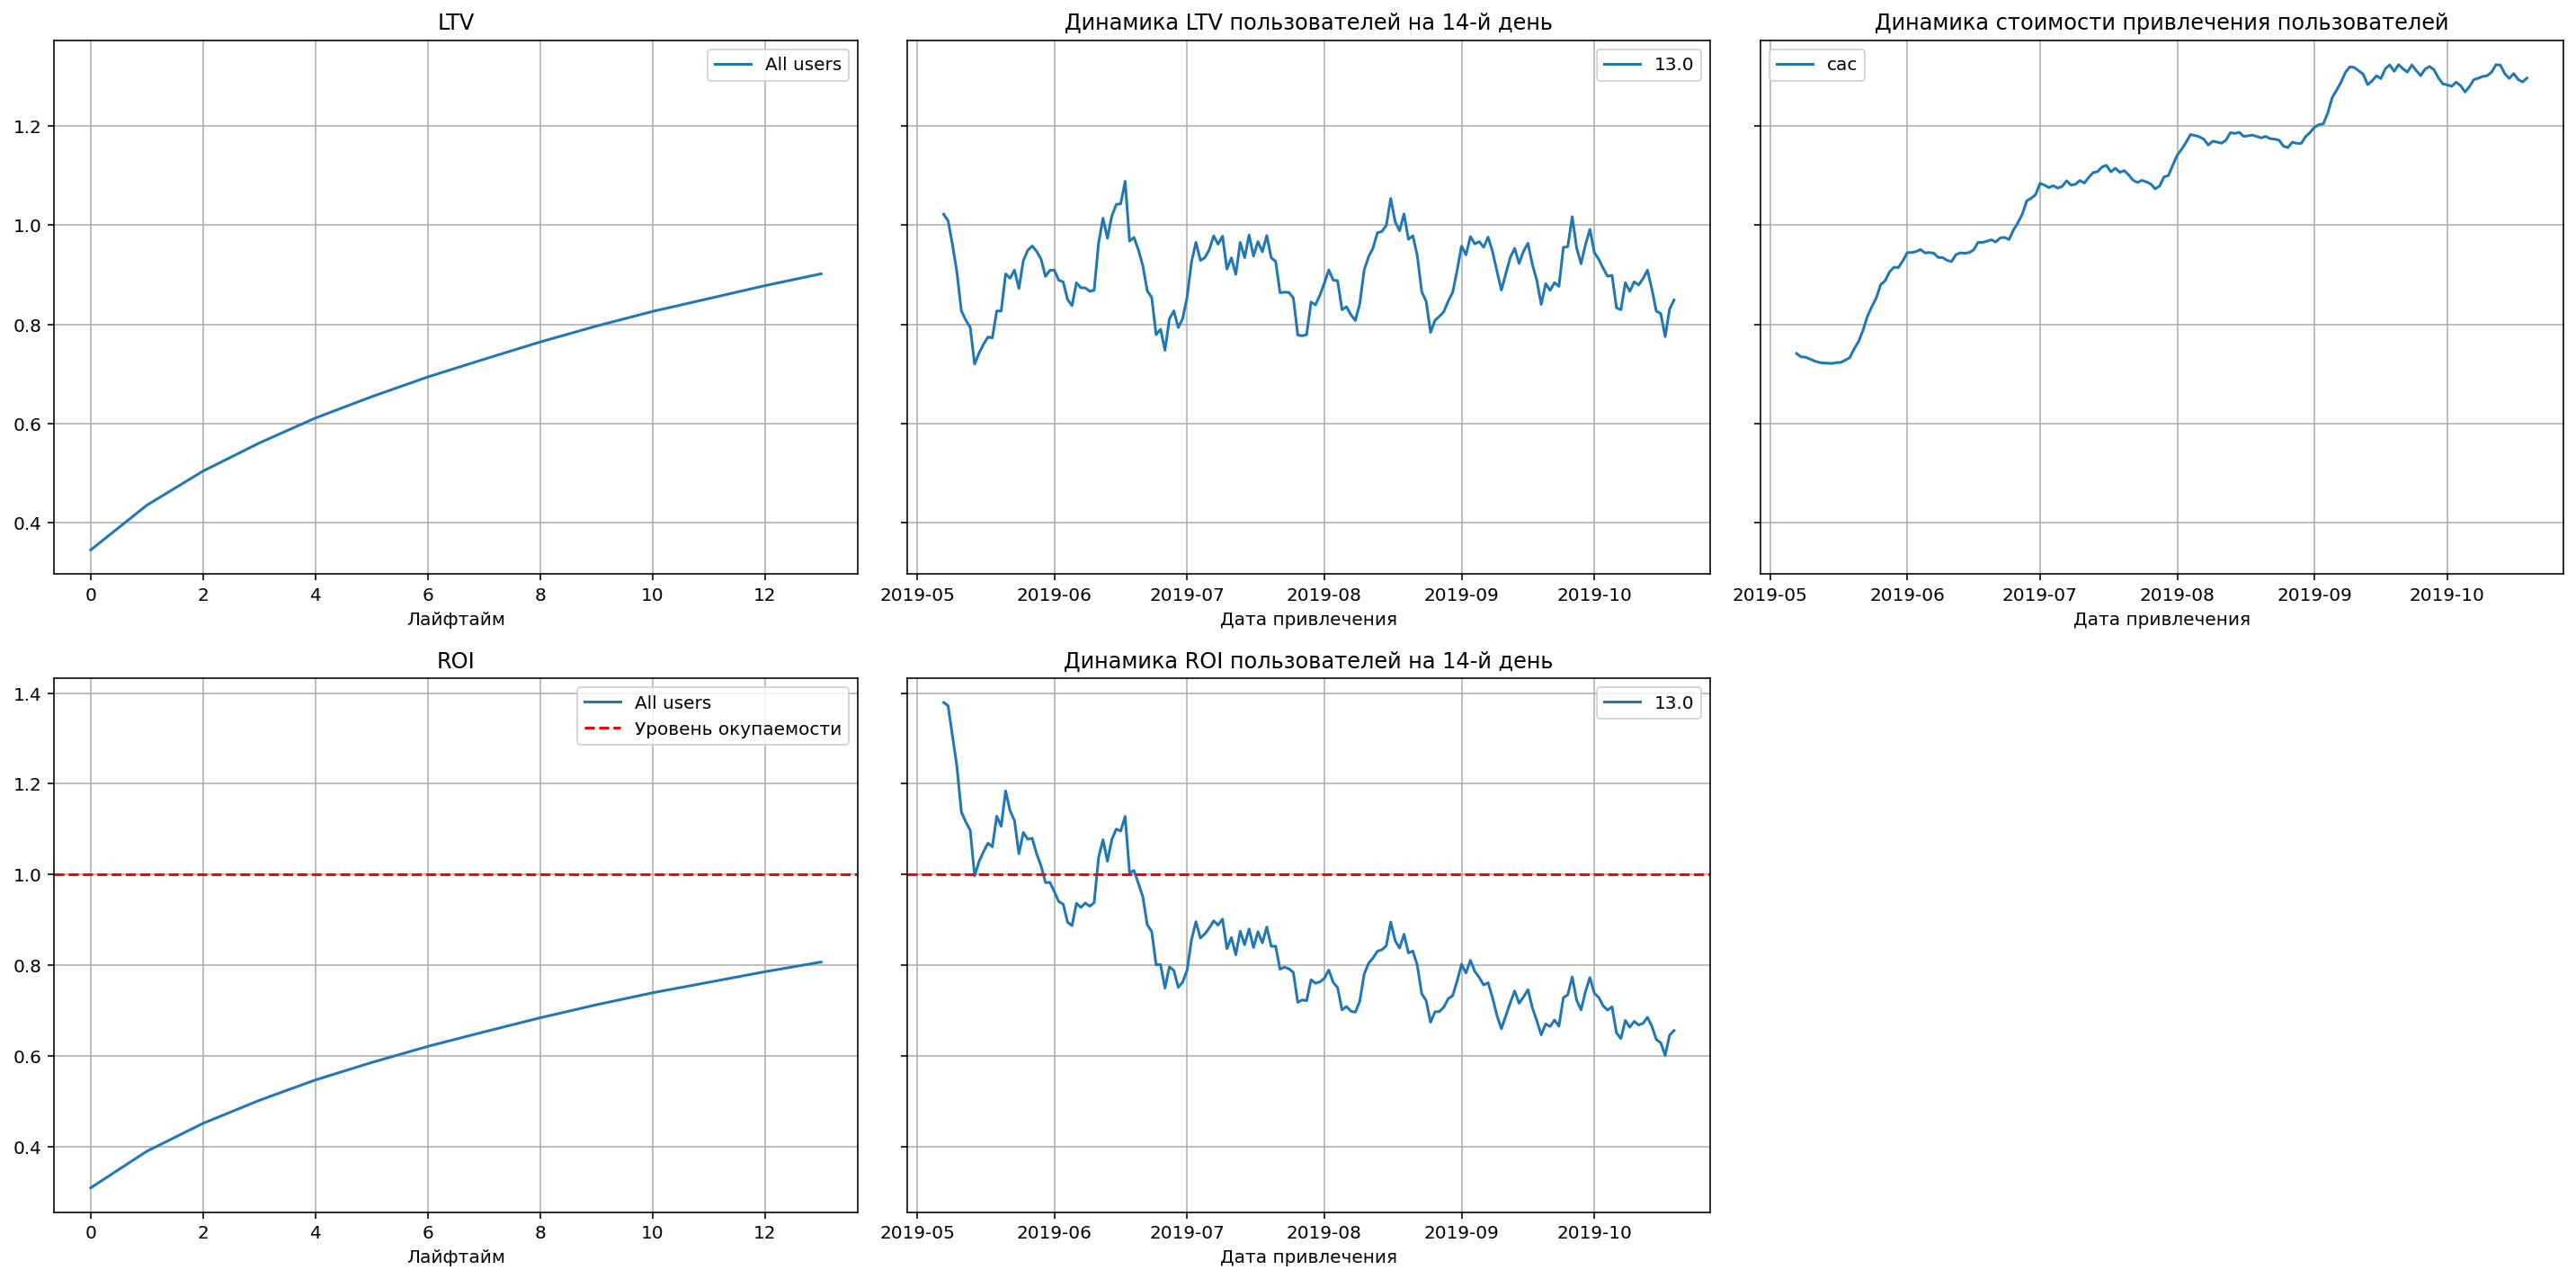

In [35]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_paid, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

По графикам можно сделать такие выводы:

- CAC резко вырос со второго месяца рекламной кампании и продолжает расти. Вероятно, маркетологи выбрали слишком дорогой канал привлечения
- LTV довольно стабильный
- ROI падает с каждым днем, динамика отрицательная. Реклама окупалась только в первые 2,5 месяца рекламной кампании
- На текущий момент ROI для клиента за 14 дней отрицательный, реклама не окупается

#### Проанализируем окупаемость рекламы с разбивкой по устройствам

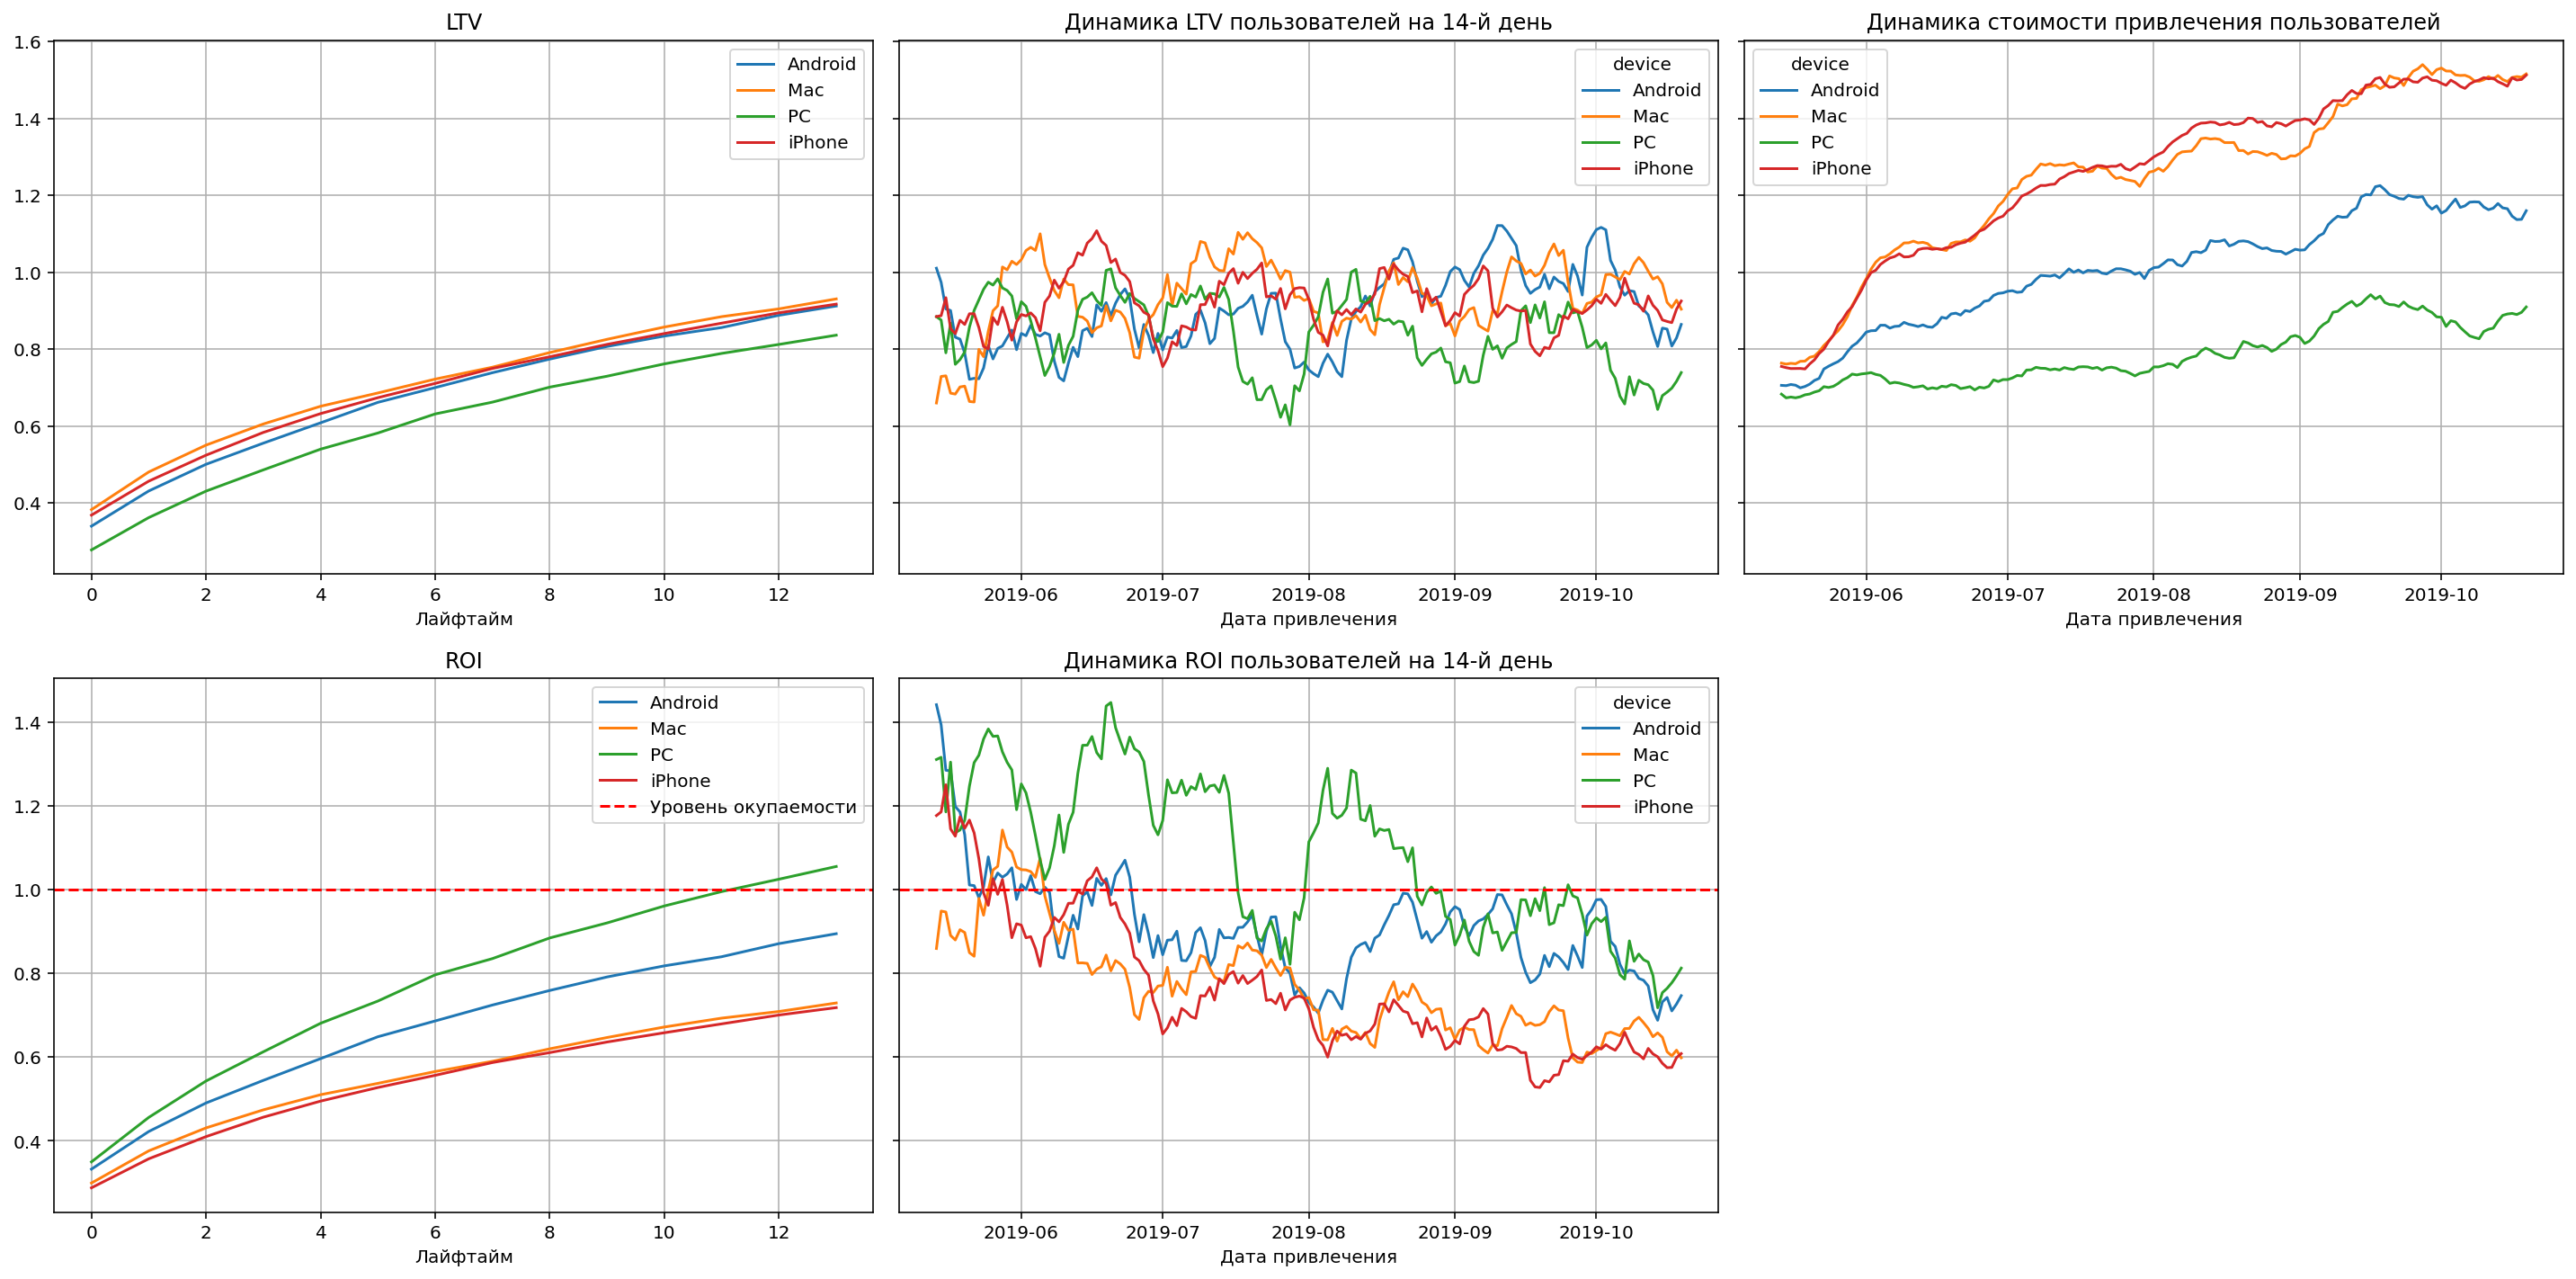

In [36]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_paid, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

По графикам можно сделать такие выводы:

- Пользователи iPhone и Mac стоят маркетингу дороже всего, но при этом не окупаются
- Пользователи PC начинают окупаться с конца второй недели, при этом у них самый низкий CAC
- Пользователи других устройств на данный момент не окупаются

#### Проанализируем окупаемость рекламы с разбивкой по странам

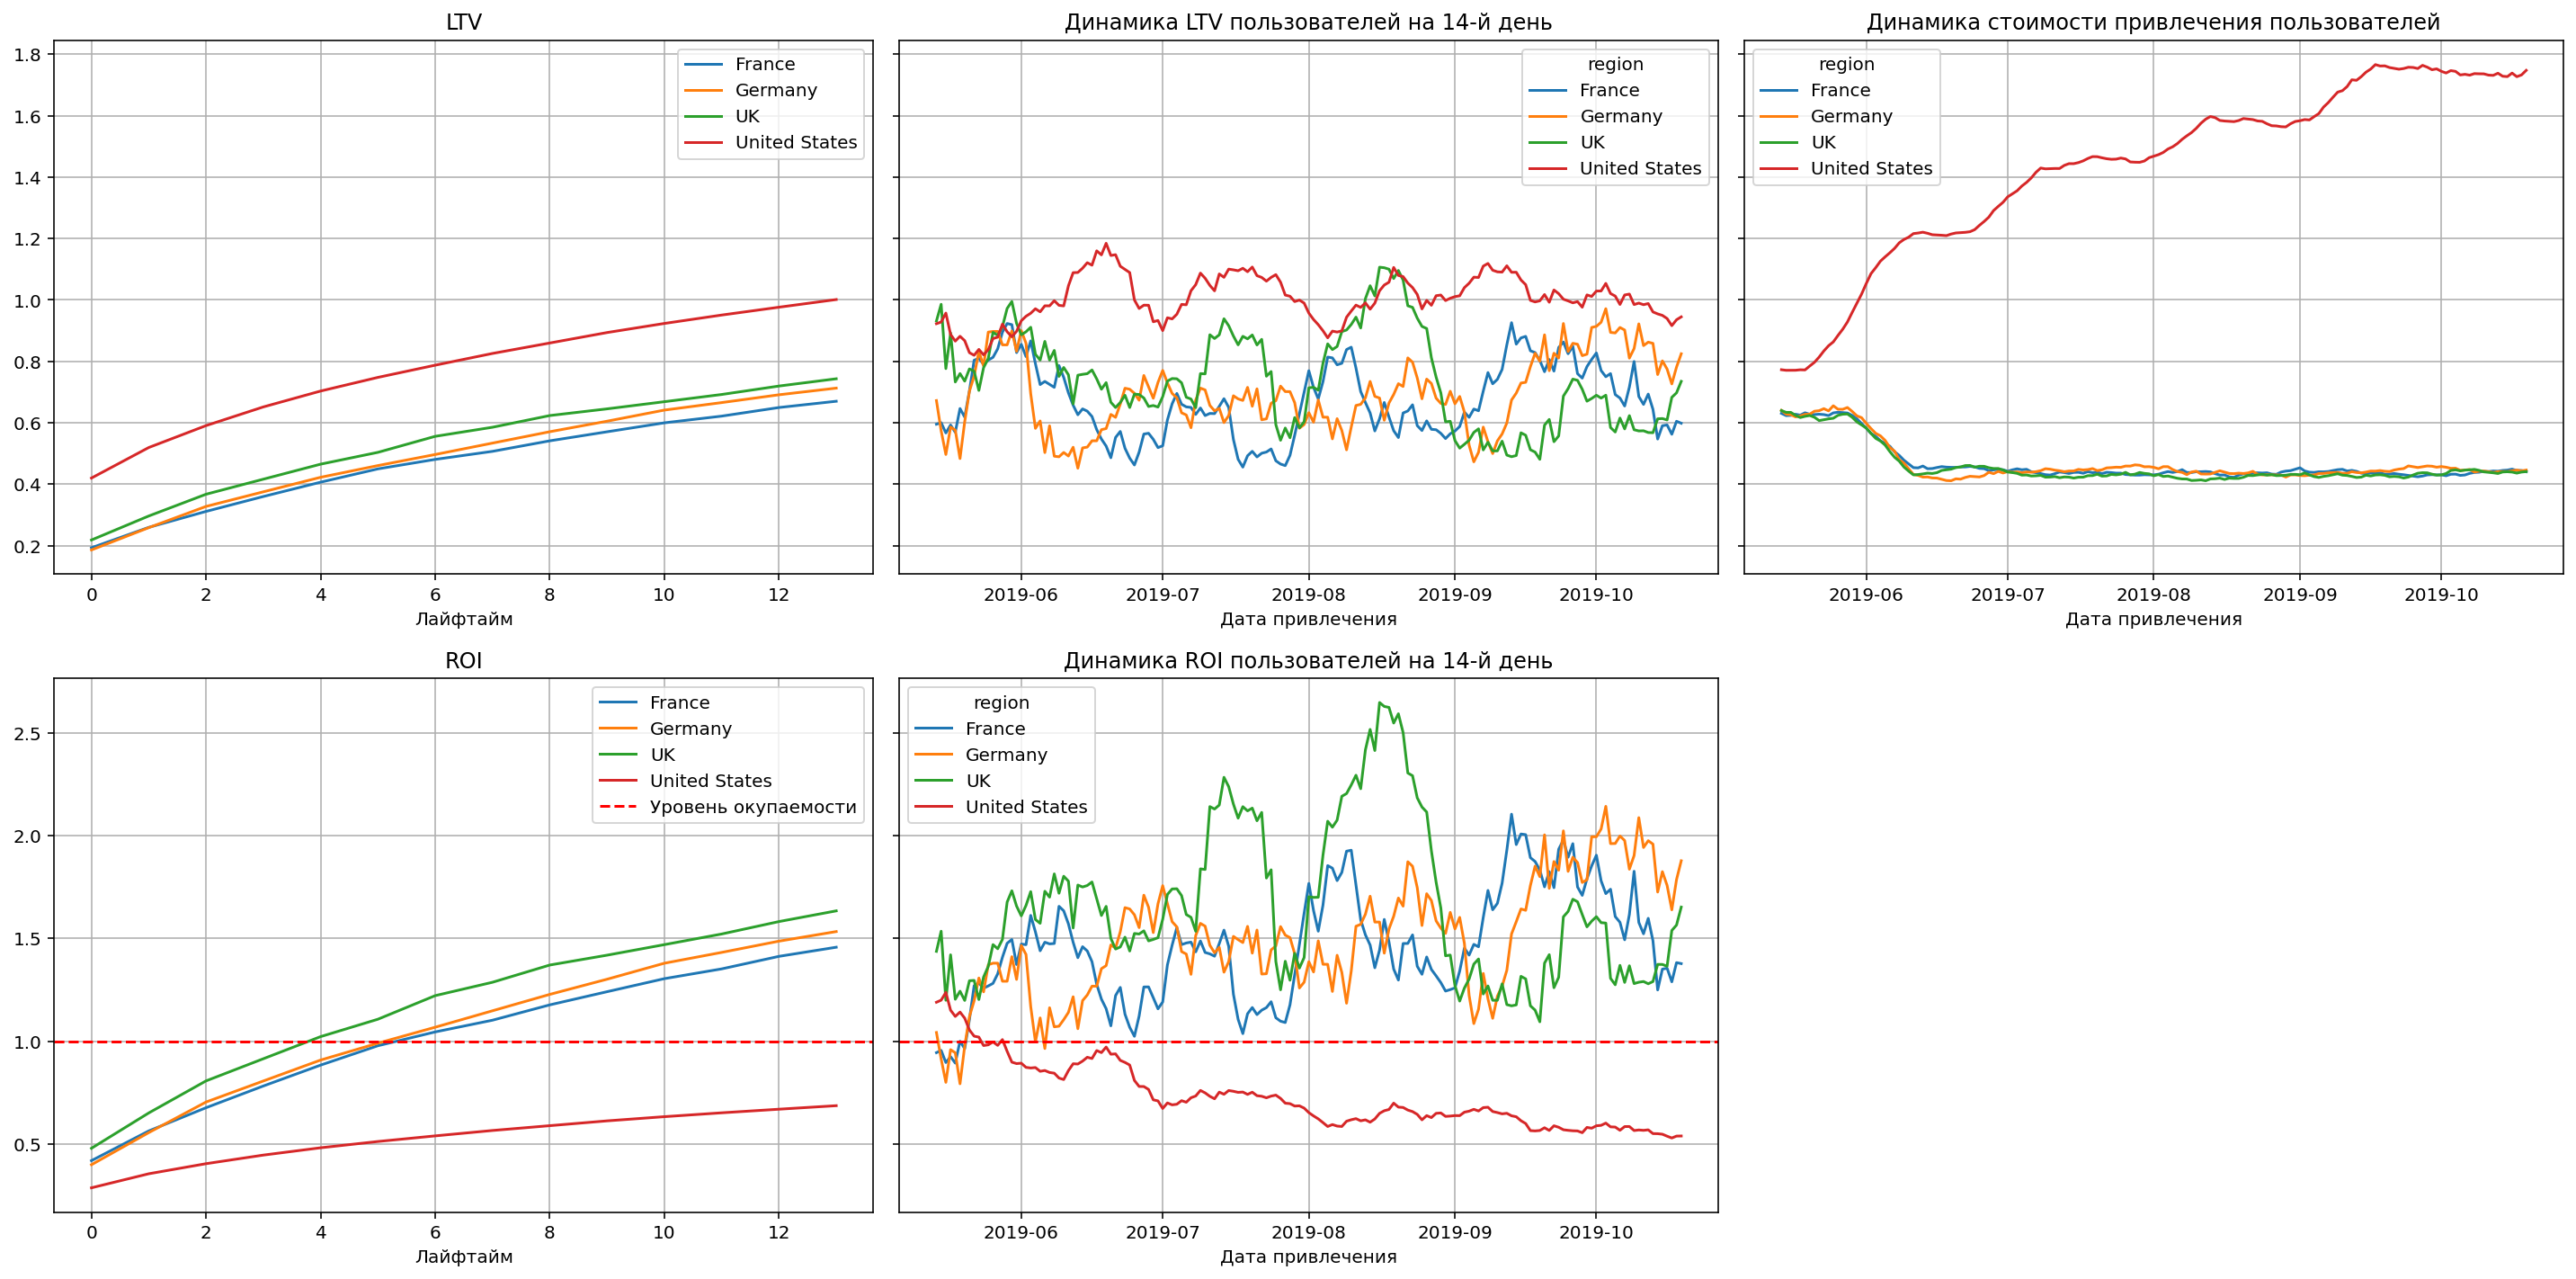

In [37]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_paid, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Судя по графикам:

- Самый высокий LTV — у пользователей из США. Затем идут Германия и Великобритания. Пользователи из Франции приносят приложению меньше всего выручки
- Самая дорогая стоимость привлечения – у пользователей из США. График практически идентичен показателю CAC с канала TipTop
- Пользователи из США никогда не окупались, ROI отрицательный
- Самые выгодные – пользовали из Великобритании, у них самый высокий ROI, за ними следуют пользователи из Германии. Пользователи из Франции тоже приносят доход. Все три региона начинают окупаться уже на шестой день


### Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам

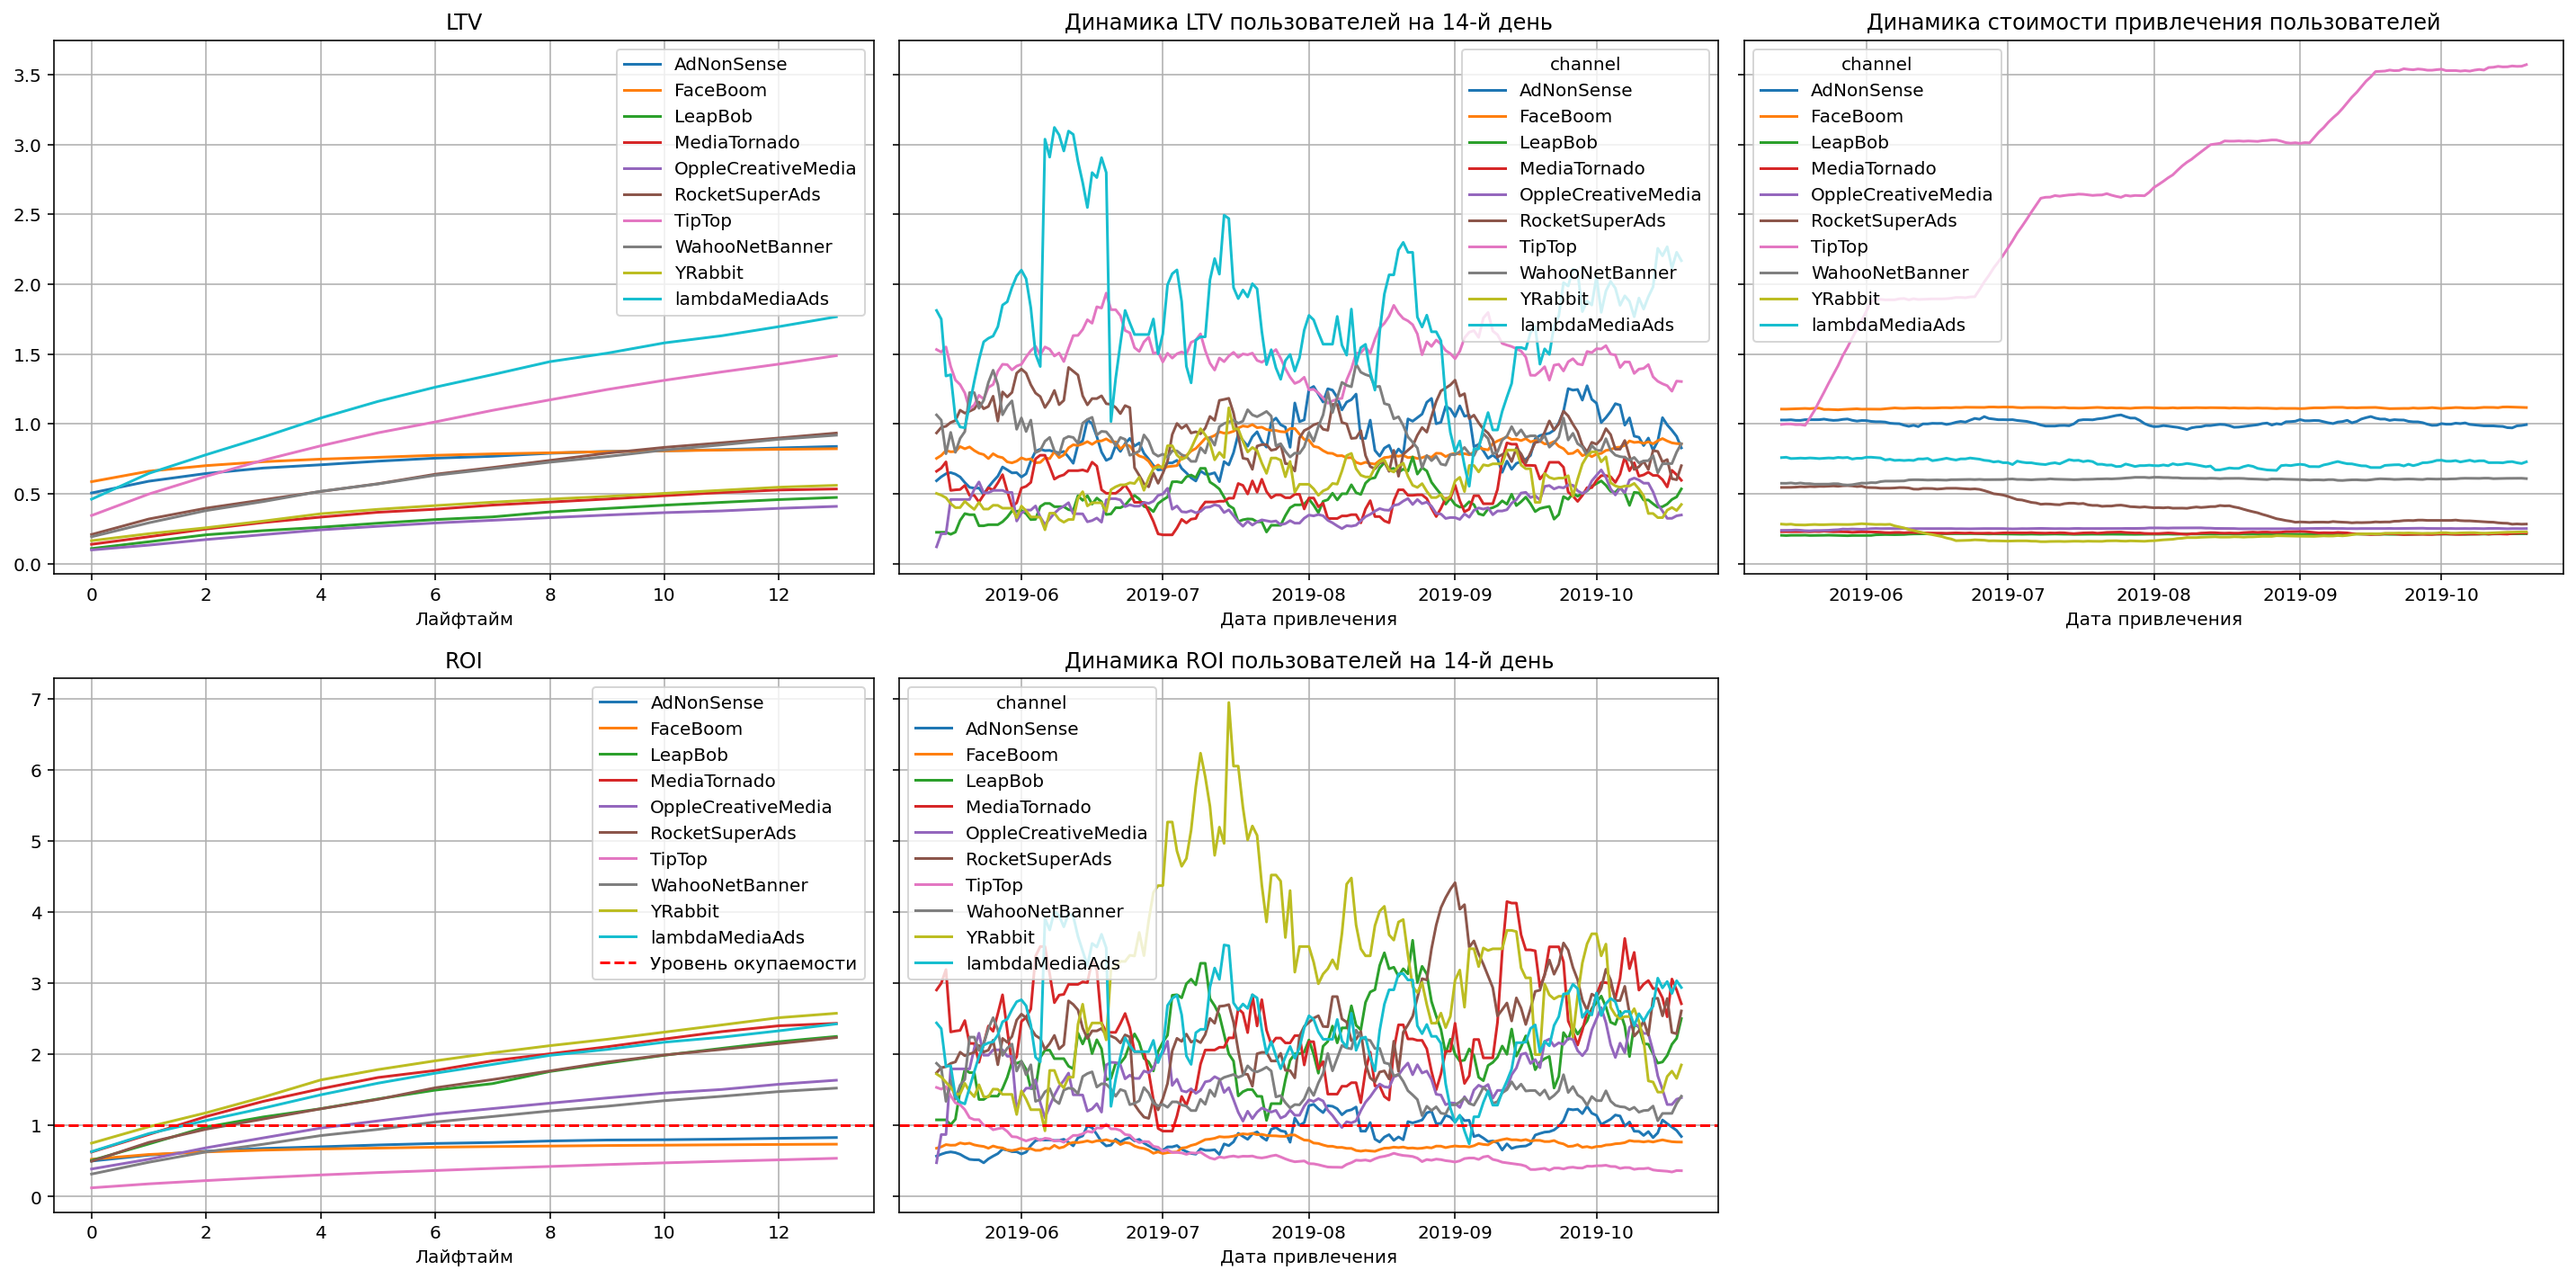

In [38]:
# смотрим окупаемость с разбивкой по источникам привлечения

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_paid, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Вот что видим на графиках:

- Стоимость привлечения по каналу TipTop резко увеличилась и продолжает расти. Учитывая, что этим каналом привлекается большой объем трафика, его показатели размывают общую картину и окупаемость рекламы выглядит плохо
- Другие каналы показывают относительную стабильность стоимости, а пара даже идет на убыль CAC
- Несмотря на высокий LTV канала TipTop, похоже, что маркетологи трятат на этот канал больше, чем зарабатывают с него – ROI канала стабильно низкий и не достигает уровня окупаемости
- Интересно выглядит канал lambdaMediaAds – у него высокий LTV и хорошая динамика, стабильный CAC и высокий ROI
- С точки зрения баланса вложений и окупаемости привлекательнее всего выглядит трафик с каналов YRabbit и MediaTornado с самыми высокими ROI и низкими CAC
- Каналы, которые совершенно не окупаются – AdNonSense, Faceboom и TipTop


#### Опишем возможные причины обнаруженных проблем и сформируем рекомендации для рекламного отдела.

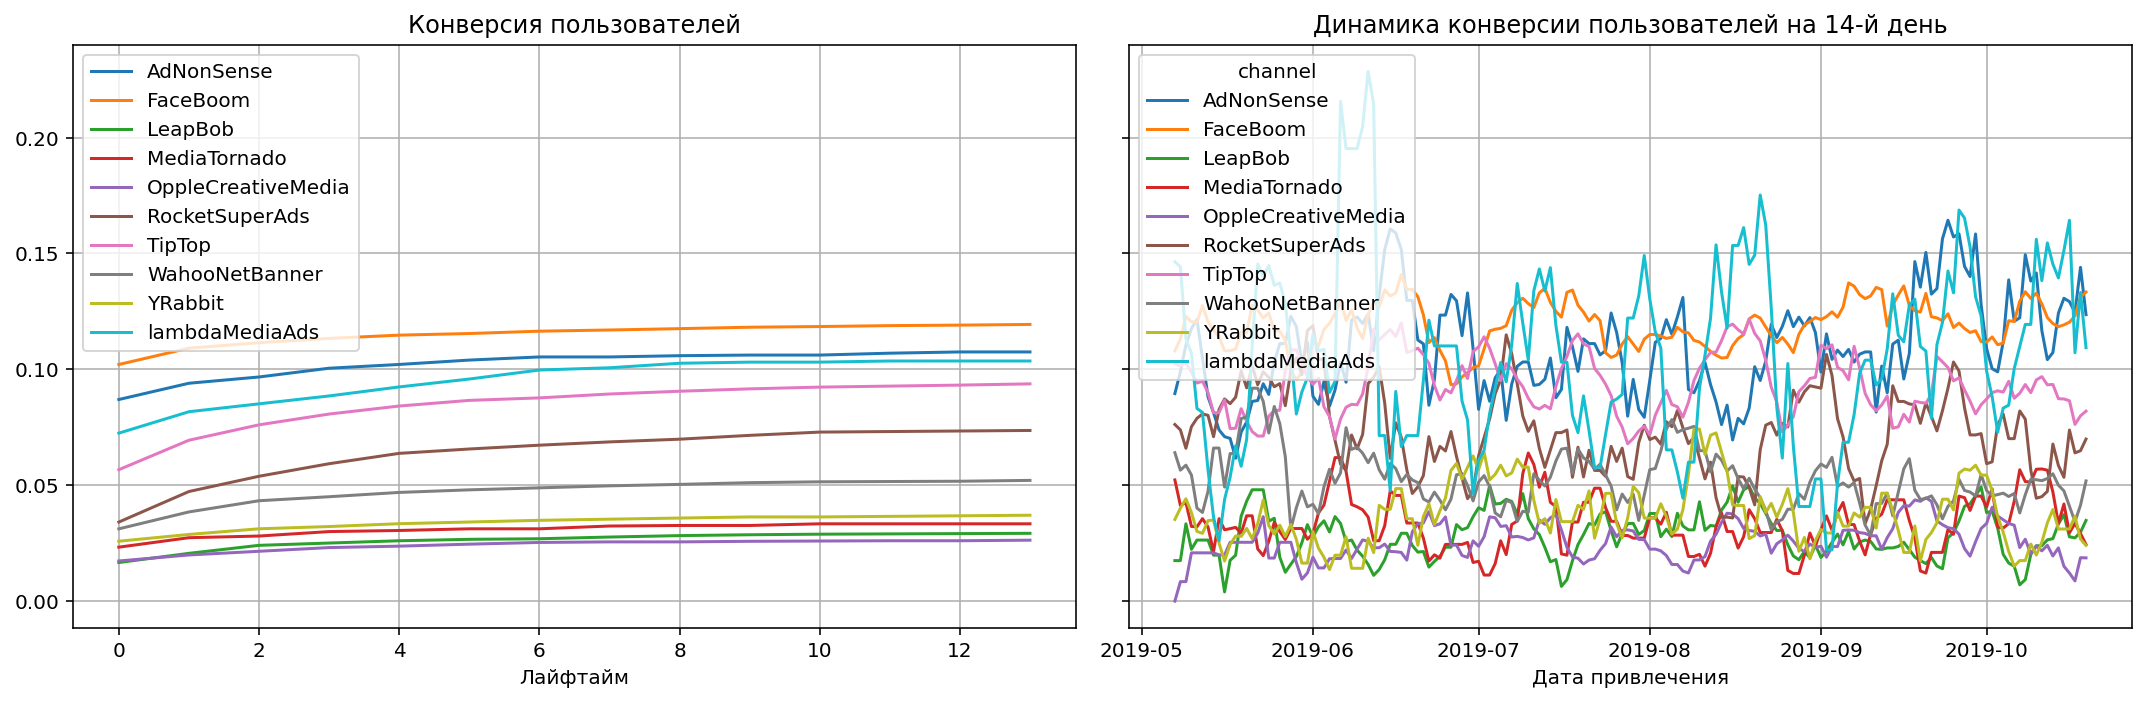

In [39]:
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_paid, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

AdNonSense и Faceboom показывают высокий уровень конверсии, TipTop тоже в пятерке лидеров.

Значит, проблема этих каналов не в конверсии.

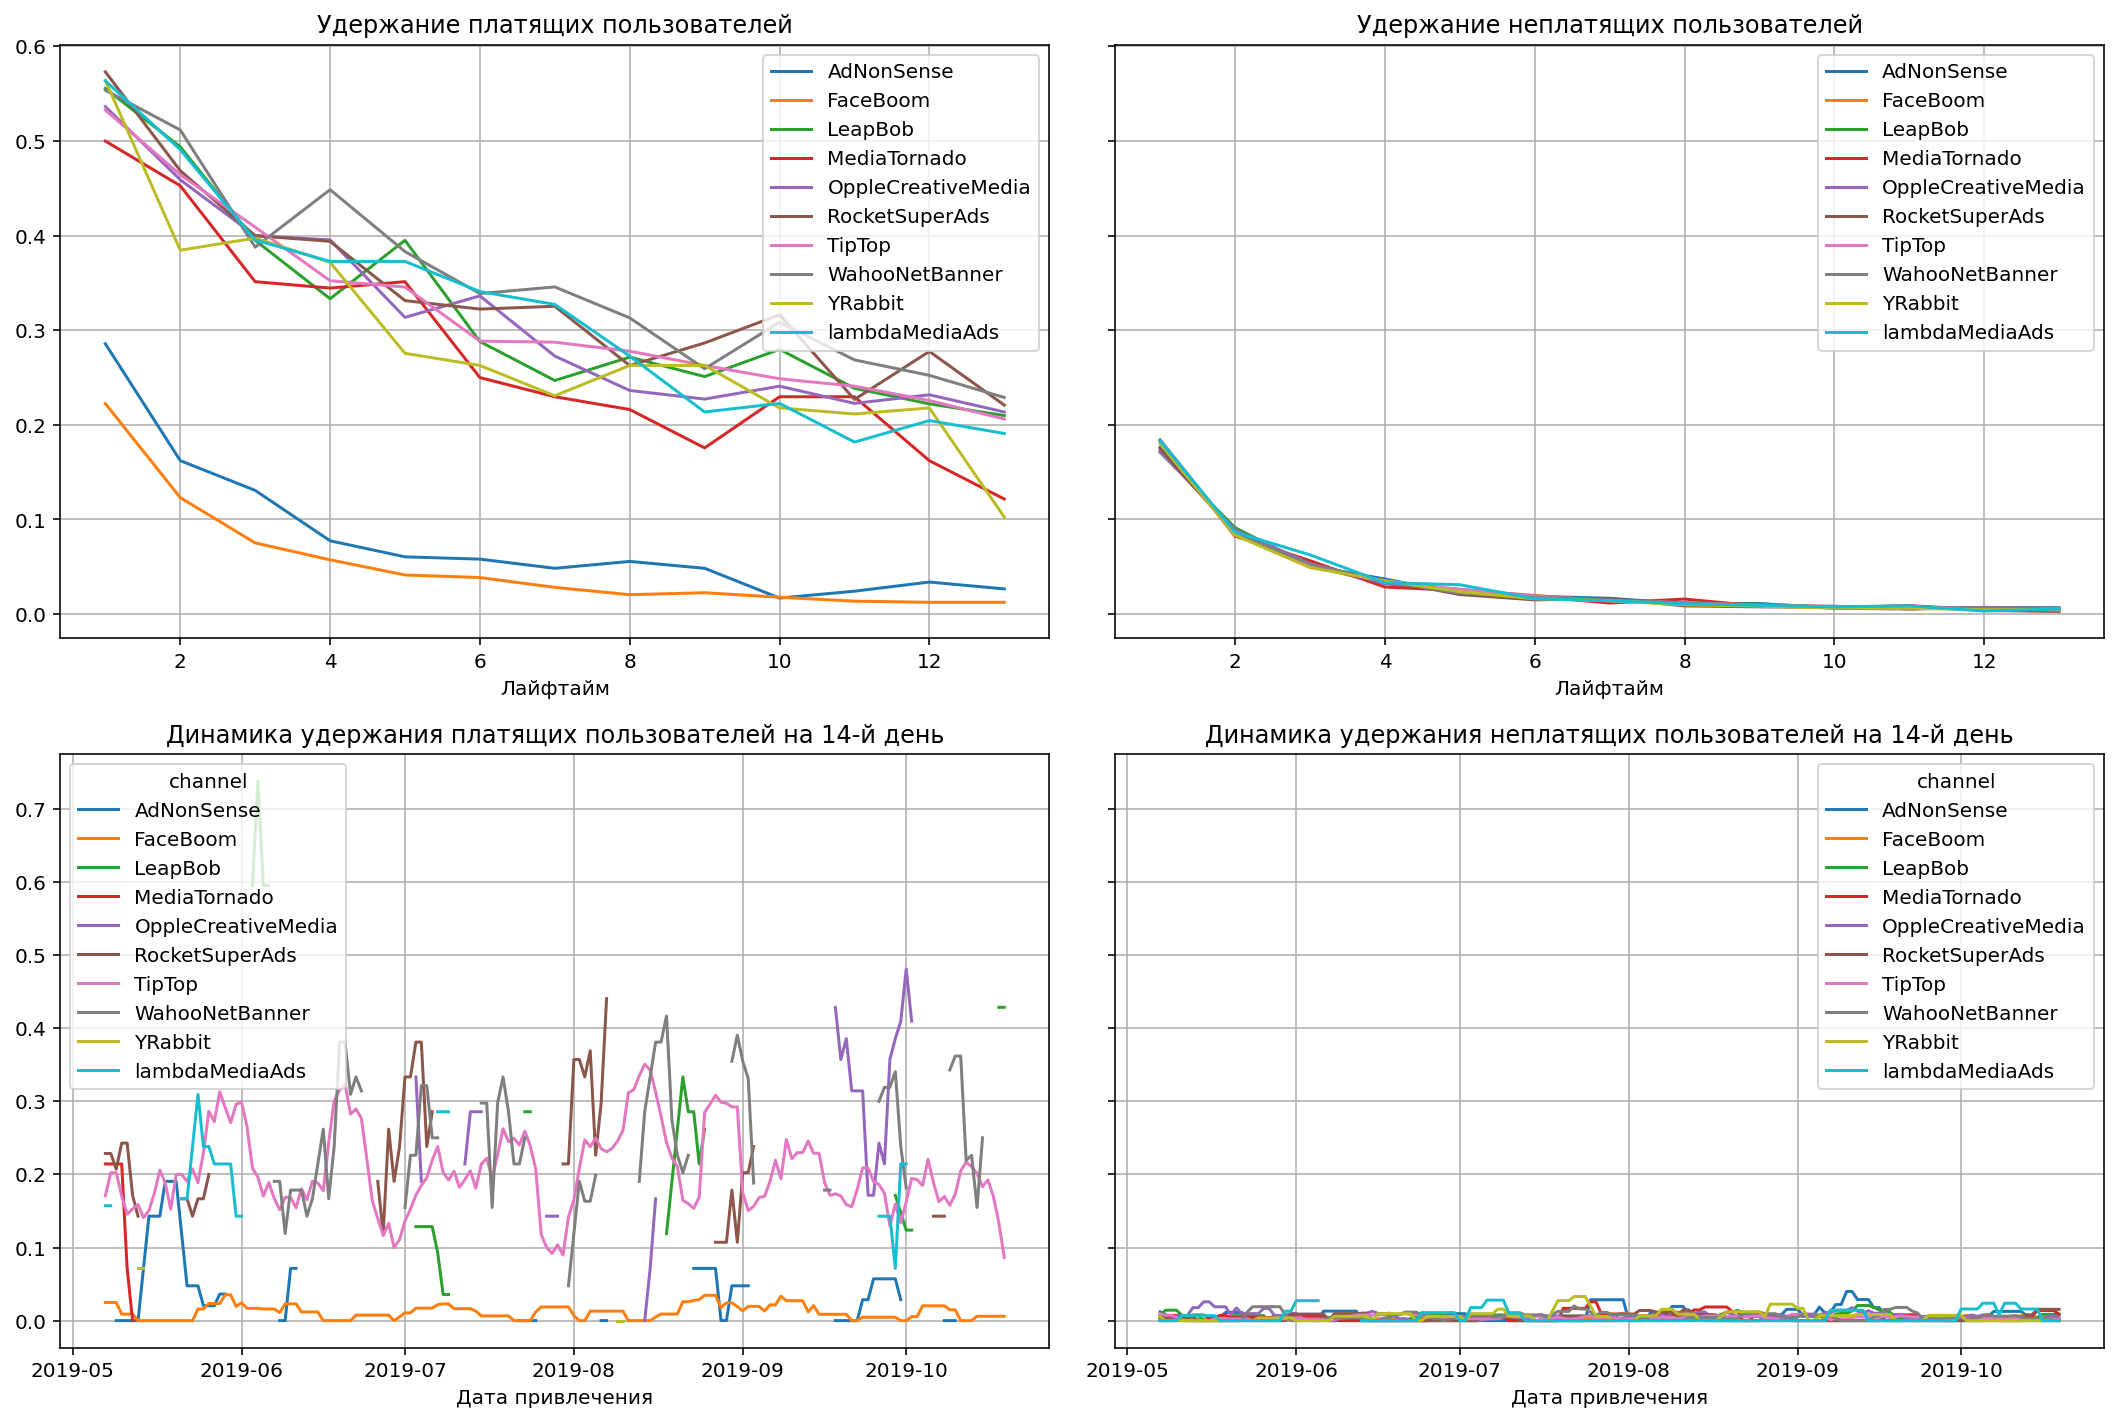

In [40]:
# смотрим удержание с разбивкой по каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_paid, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

У каналов AdNonSense и Faceboom очень низкие показатели удержания платных пользователей – пользователям неинтересен продукт.

Ползователи с канала TipTop показывают средние показатели удержания, сравнимые с другими каналами.

#### Рассмотрим подробнее метрики, сгруппированные по неэффективным каналам и регионам

In [41]:
# стоимость привлечения по каналам в разных регионах

profiles_paid \
    .groupby(['channel', 'region']) \
    .agg({'acquisition_cost': 'mean'}) \
    .sort_values(by='acquisition_cost', ascending=False)

acquisition_cost
channel            region                         
TipTop             United States             2.799
FaceBoom           United States             1.113
AdNonSense         Germany                   1.008
                   UK                        1.008
                   France                    1.008
lambdaMediaAds     UK                        0.727
                   Germany                   0.726
                   France                    0.721
WahooNetBanner     UK                        0.602
                   France                    0.602
                   Germany                   0.602
RocketSuperAds     United States             0.412
OppleCreativeMedia Germany                   0.250
                   UK                        0.250
                   France                    0.250
YRabbit            United States             0.219
MediaTornado       United States             0.219
LeapBob            Germany                   0.210
                   France                    0.210
                   UK                        0.210

Видим, что неэффективные каналы TipTop и Faceboom используются для продвижения только в США.

Тогда как AdNonSense, наоборот, используются для продвижения только в странах Европы.

Посмотрим, как выглядели бы результаты без этих каналов:

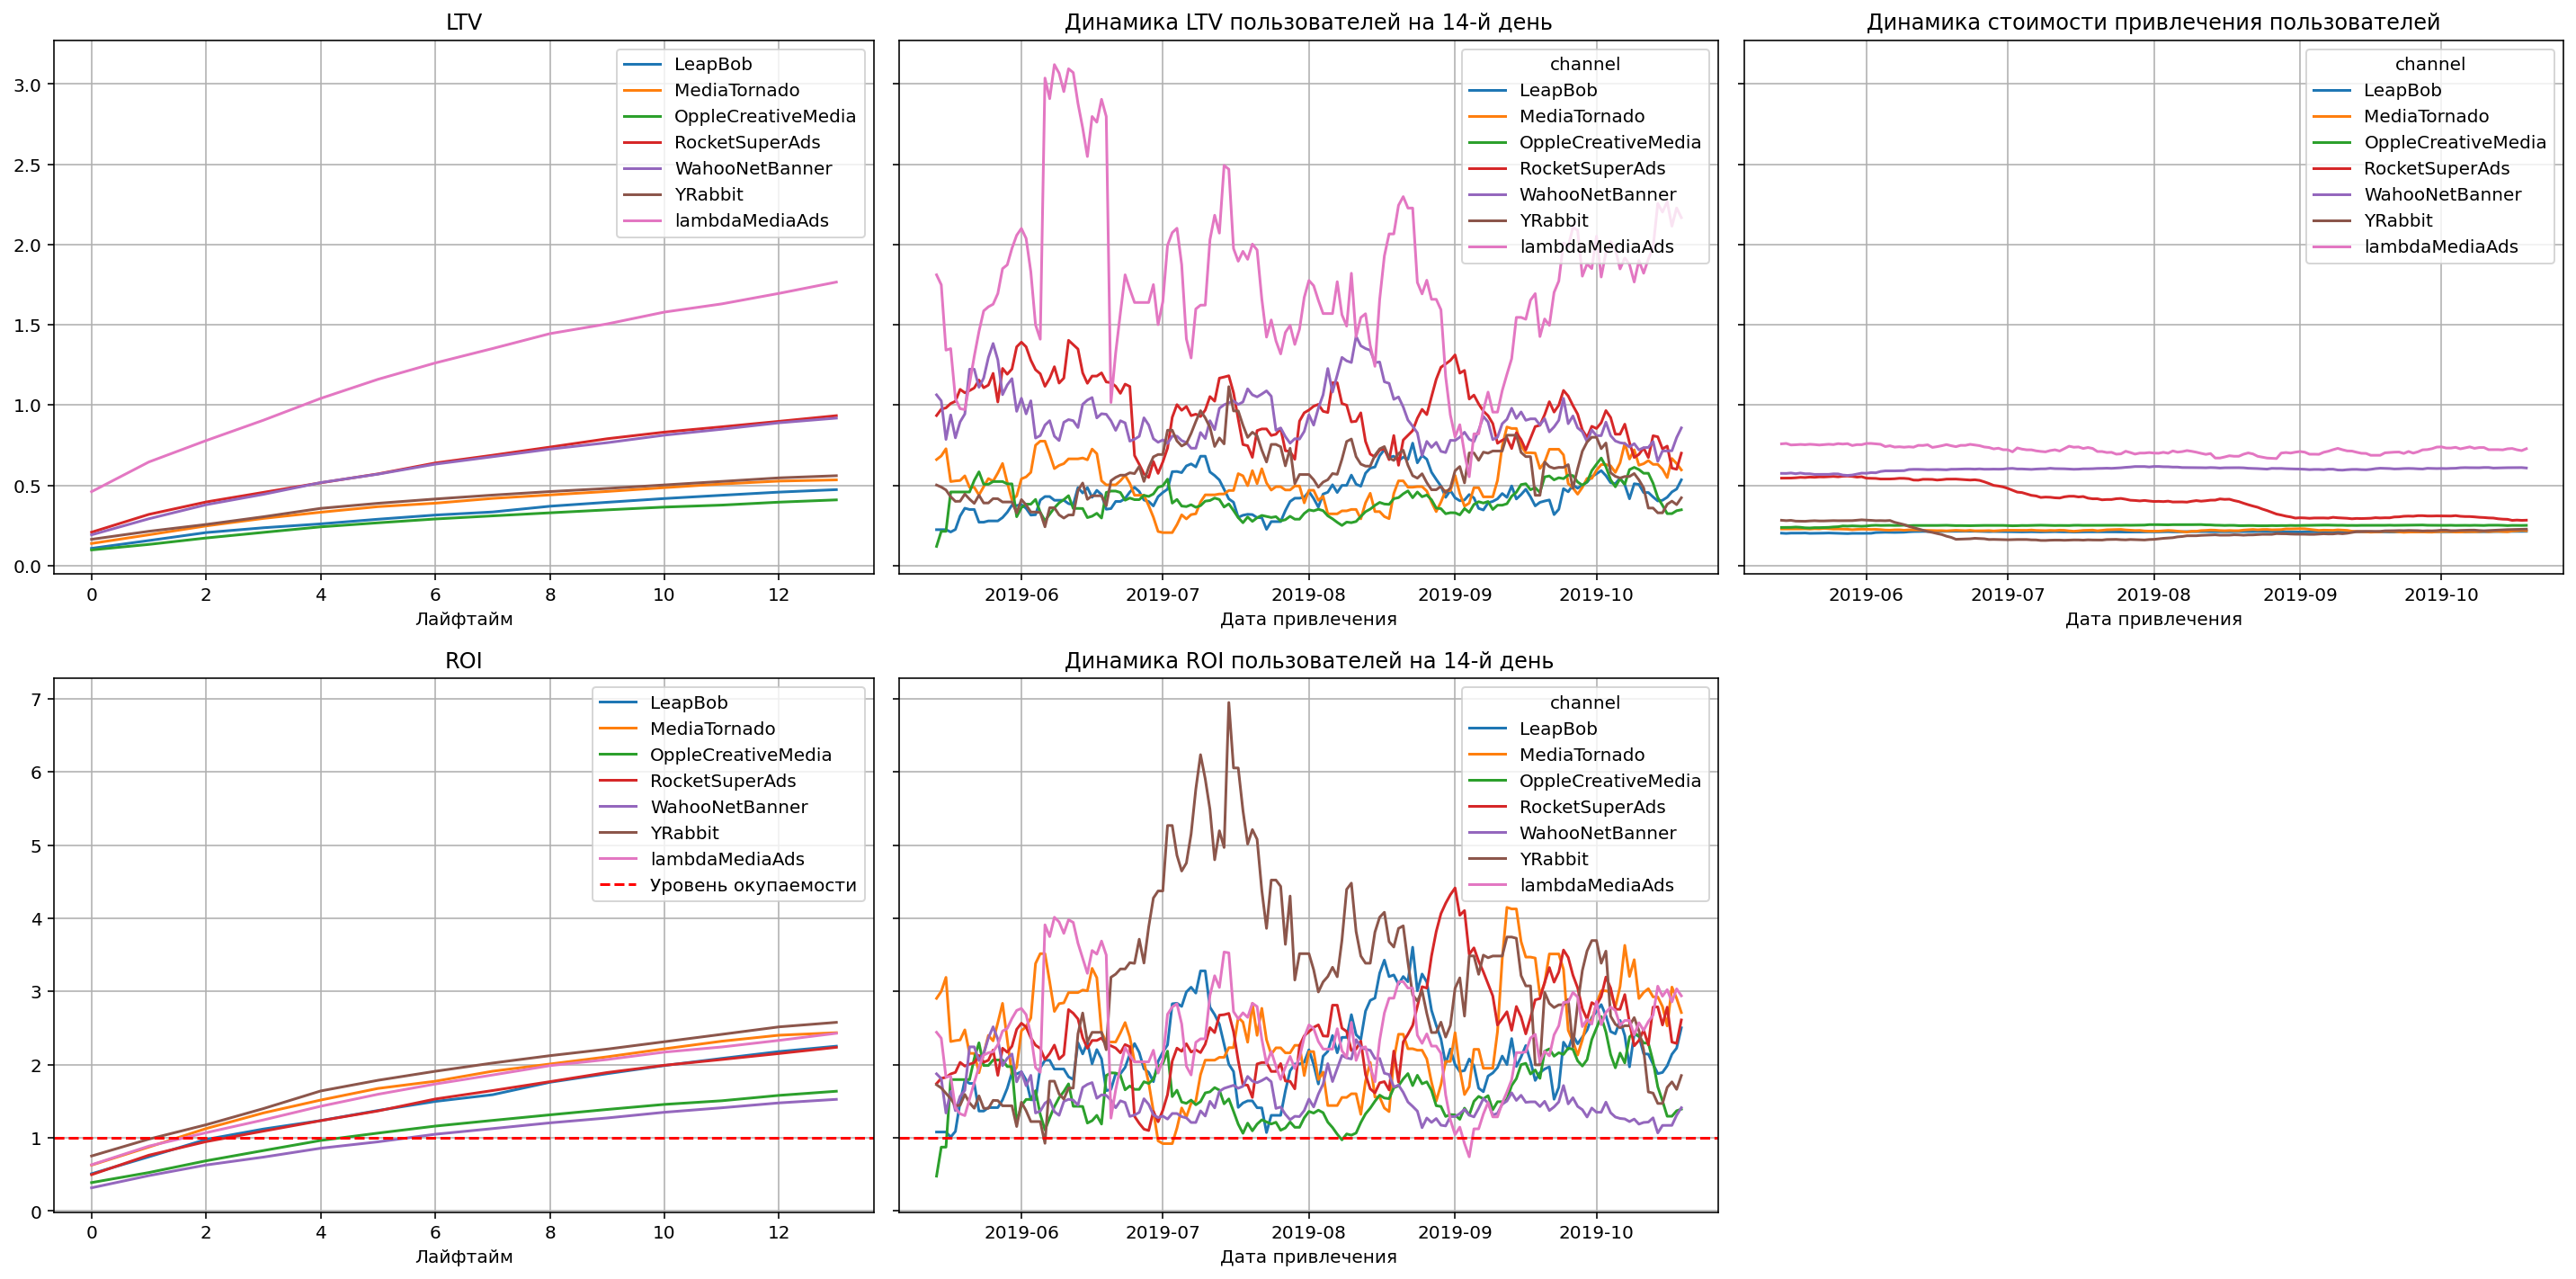

In [42]:
# список с неэффективными каналами
bad_channels = ['TipTop', 'FaceBoom', 'AdNonSense']

# строим графики без неэффективных каналов
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_paid.query("channel not in @bad_channels"), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Все оставшиеся каналы окупаются, особенно выделяется lambdaMediaAds с самым высоким LTV.

И посмотрим, как выглядит график без учета рекламных кампаний в США:

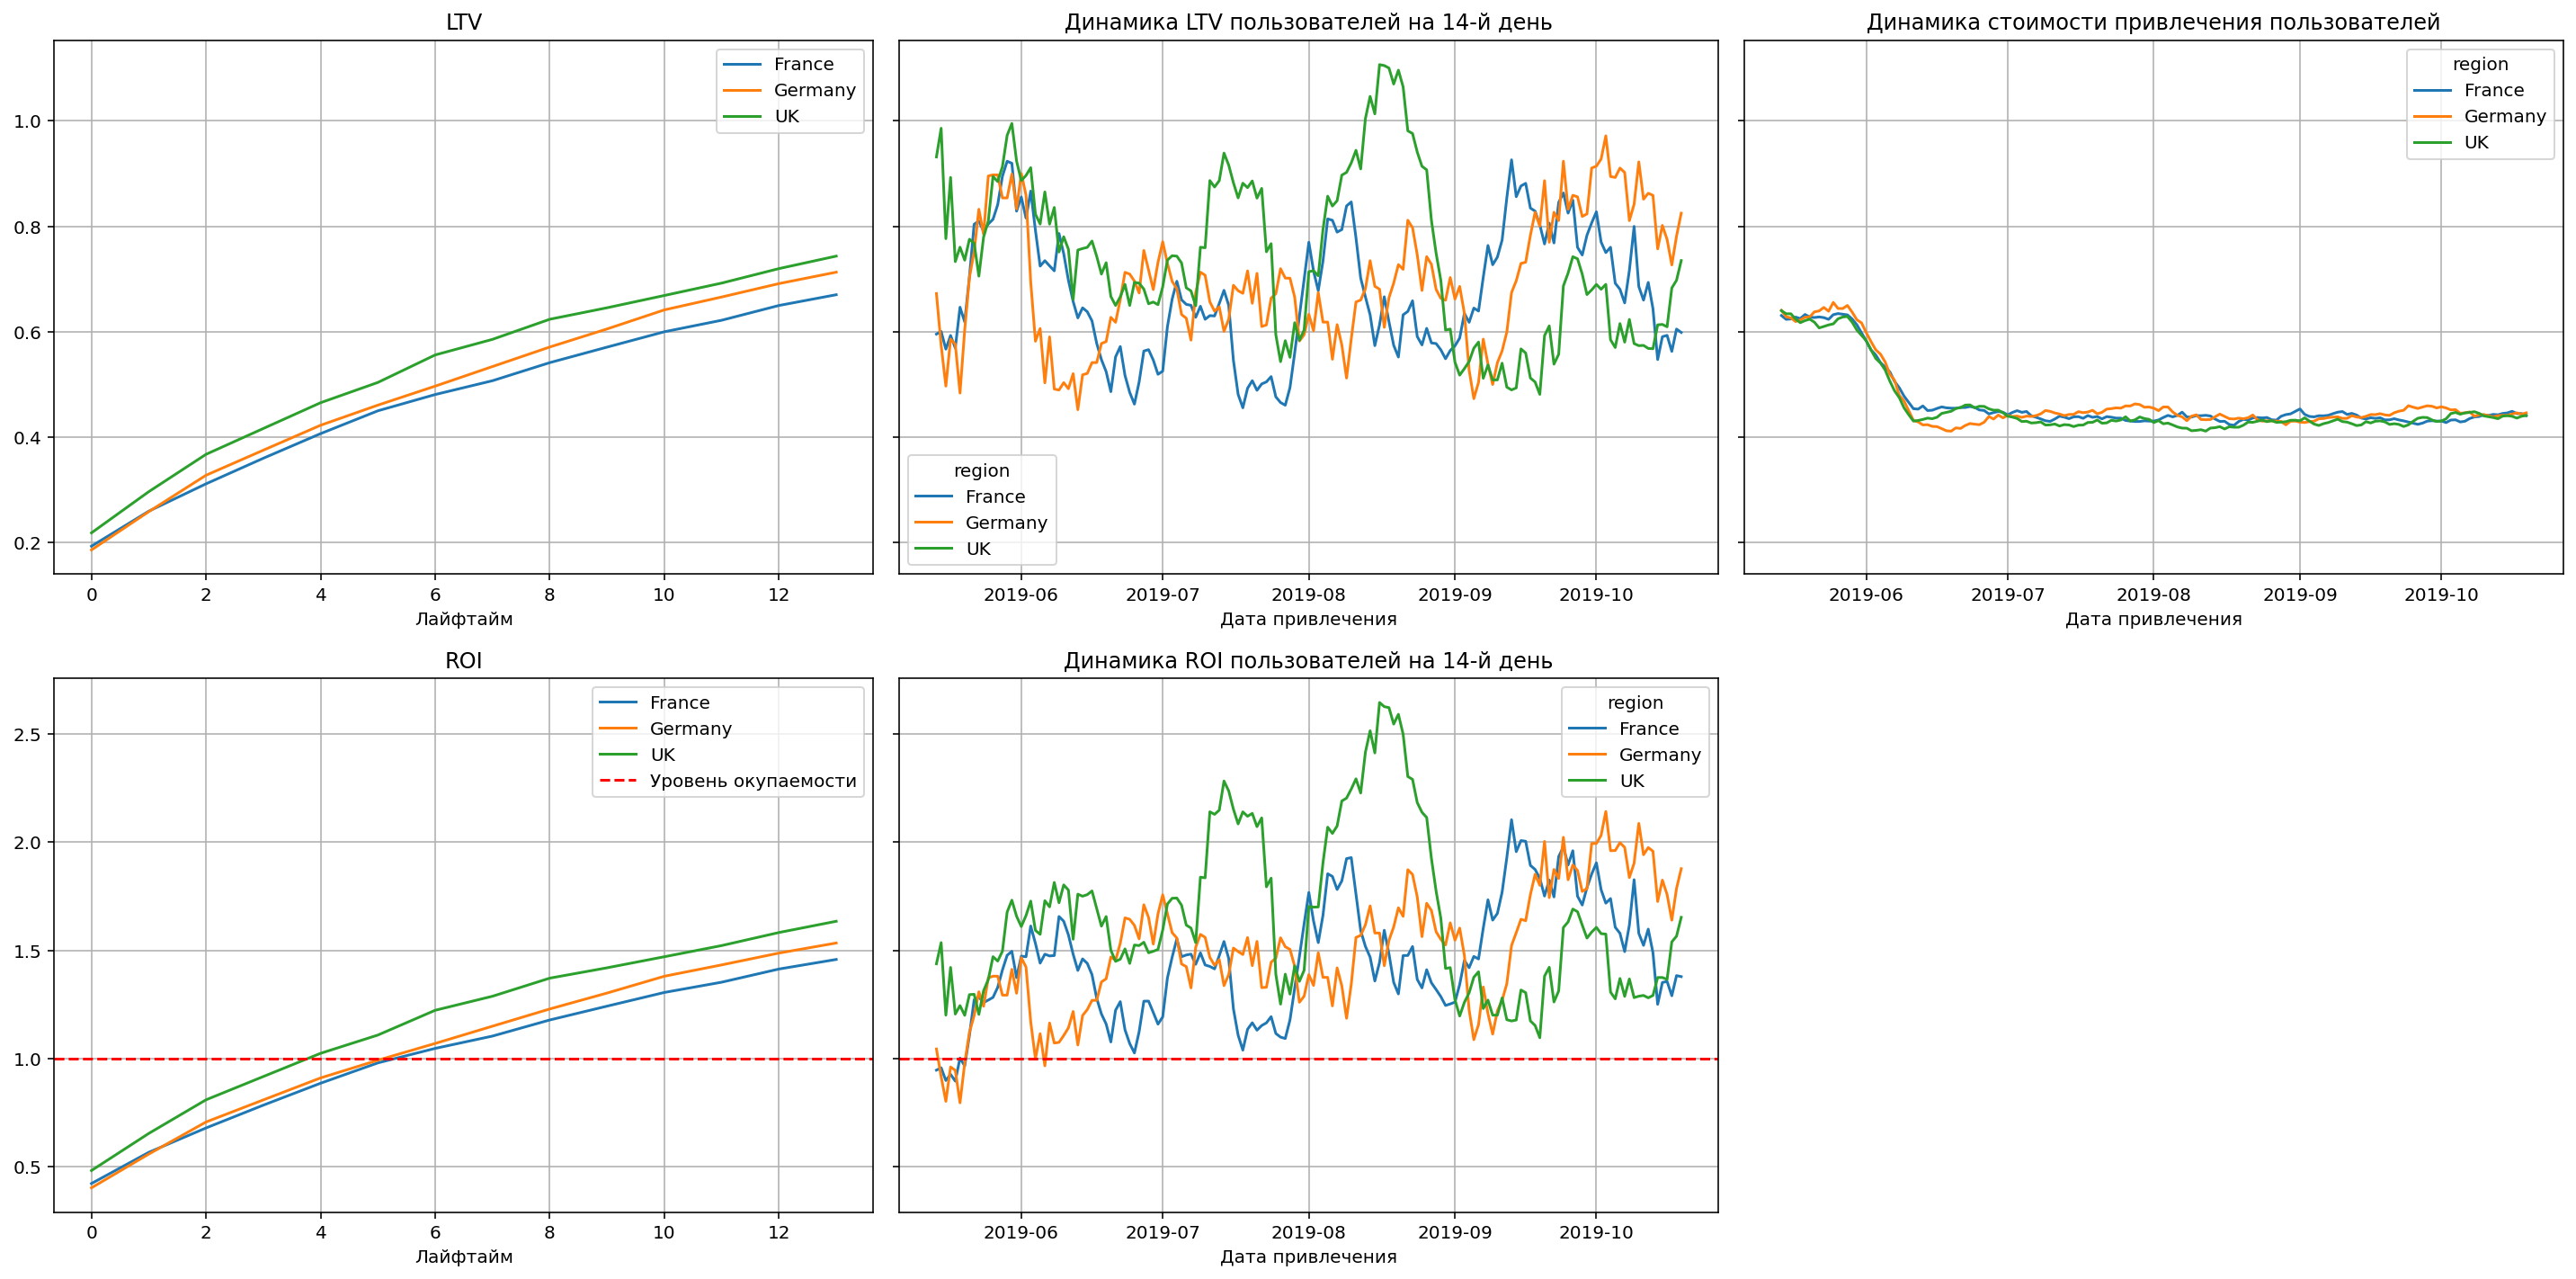

In [43]:
# строим графики без неэффективного региона
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_paid.query("region != 'United States'"), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Без рекламной кампании в США тоже хорошая окупаемость и стабильный CAC, но LTV ниже.

Учитывая, что основными каналами привлечения там являются дорогостоящие – это выглядит логичным.

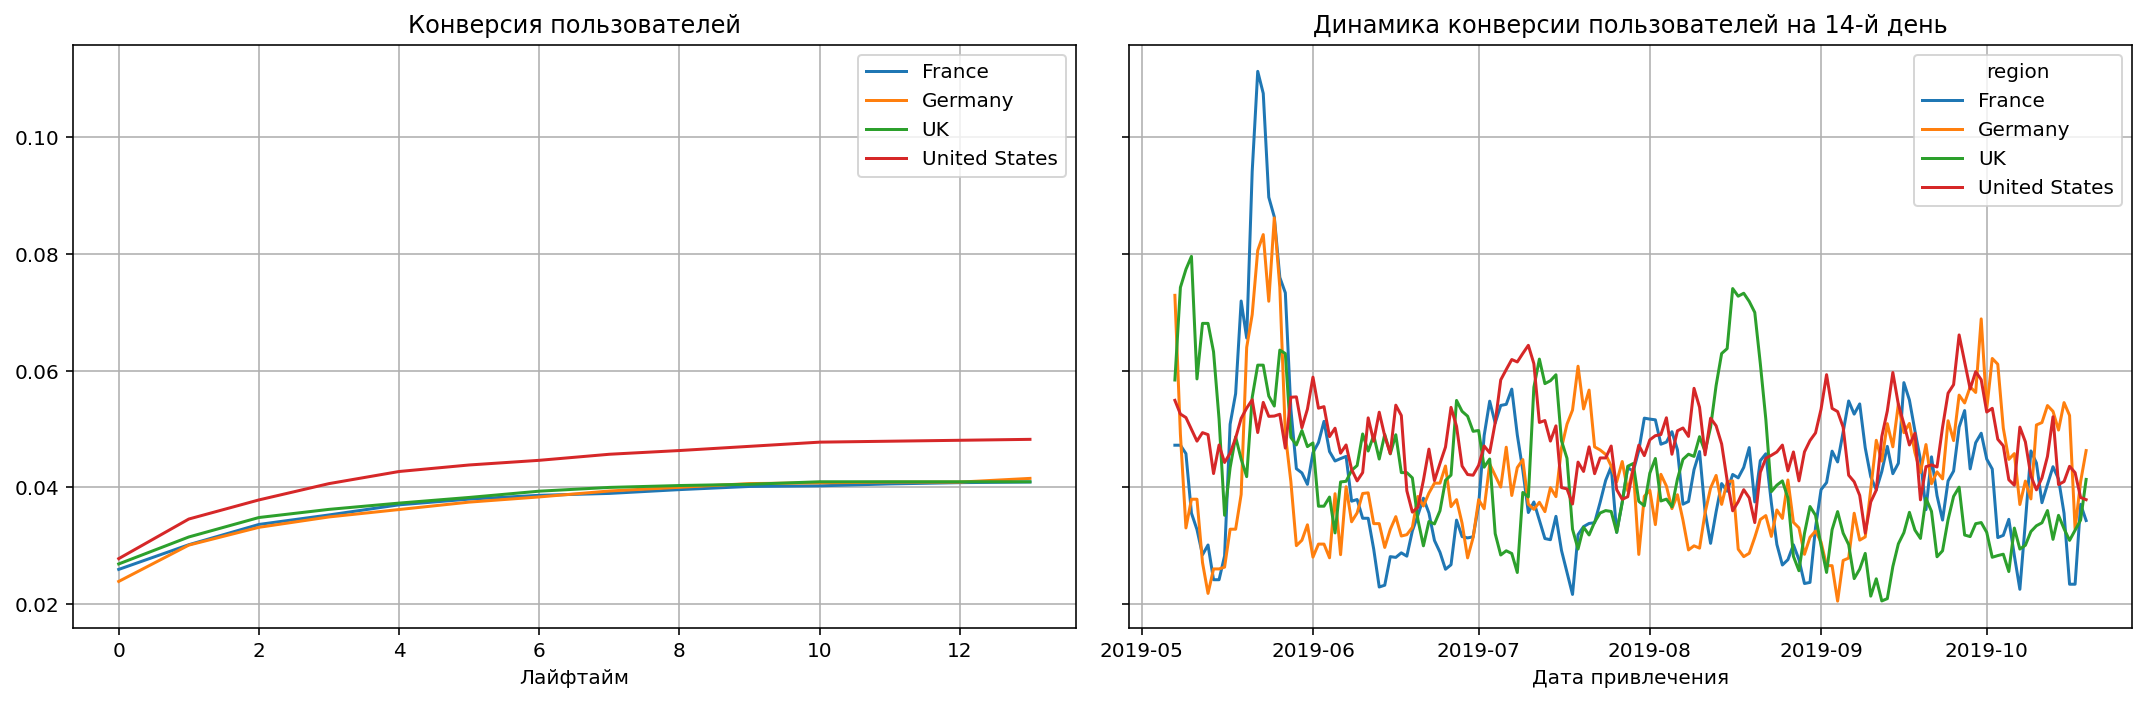

In [44]:
# смотрим конверсию с разбивкой по регионам, без неэффективных каналов

dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_paid.query("channel not in @bad_channels"), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

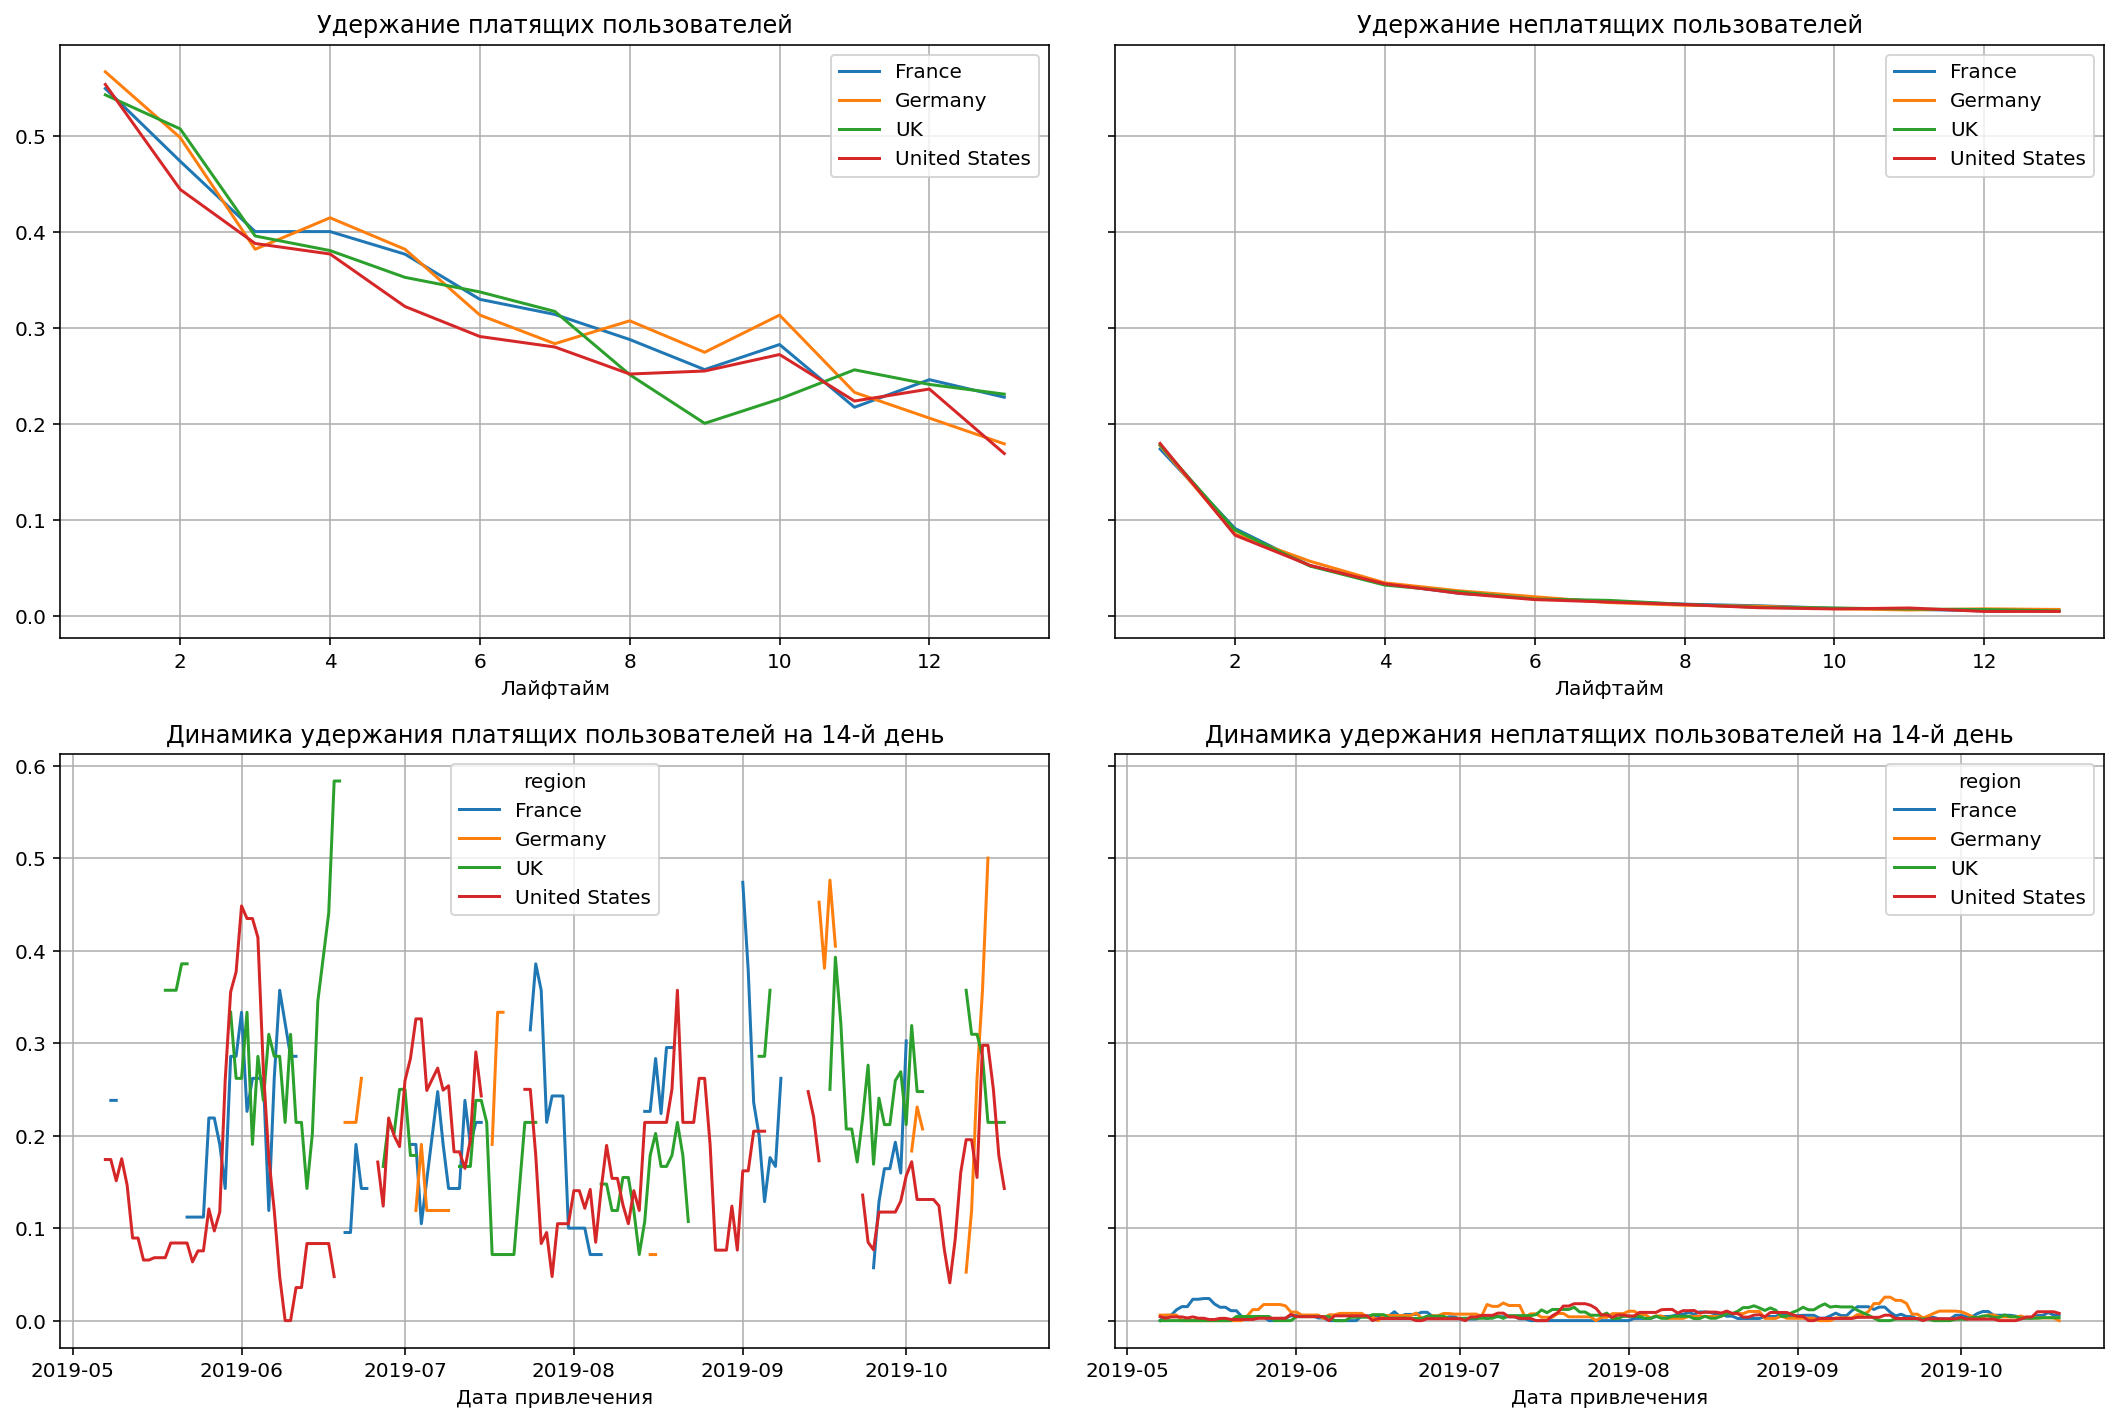

In [45]:
# смотрим удержание с разбивкой по регионам, без неэффективных каналов

dimensions = ['region']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_paid.query("channel not in @bad_channels"), visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

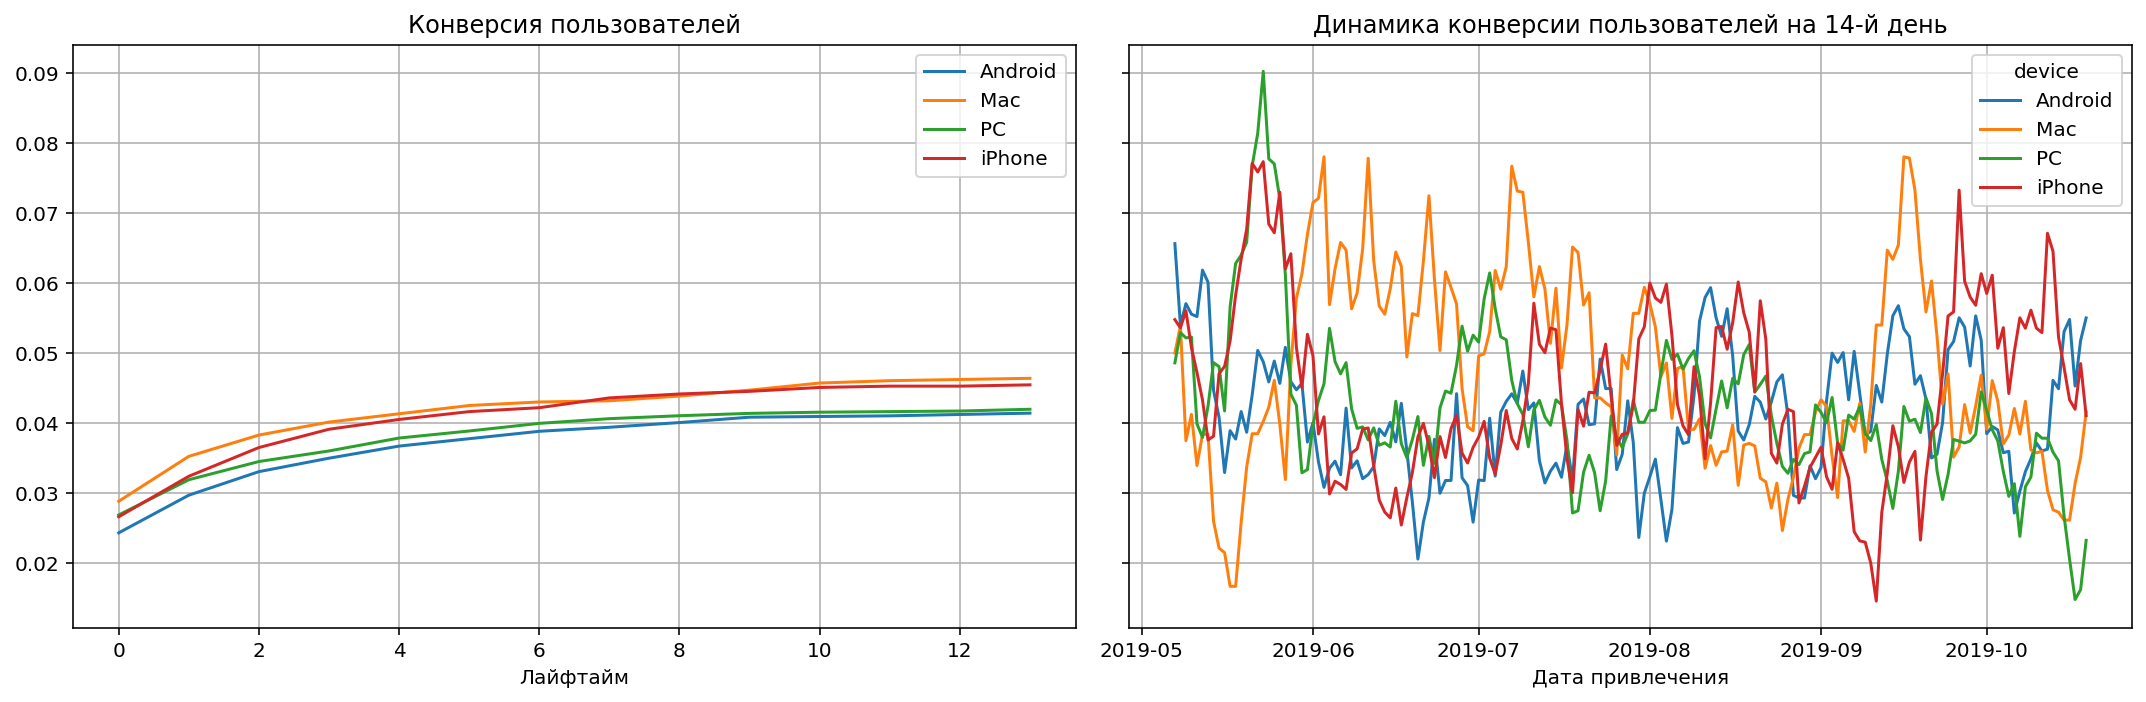

In [46]:
# смотрим конверсию с разбивкой по устройствам, без неэффективных каналов

dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_paid.query("channel not in @bad_channels"), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

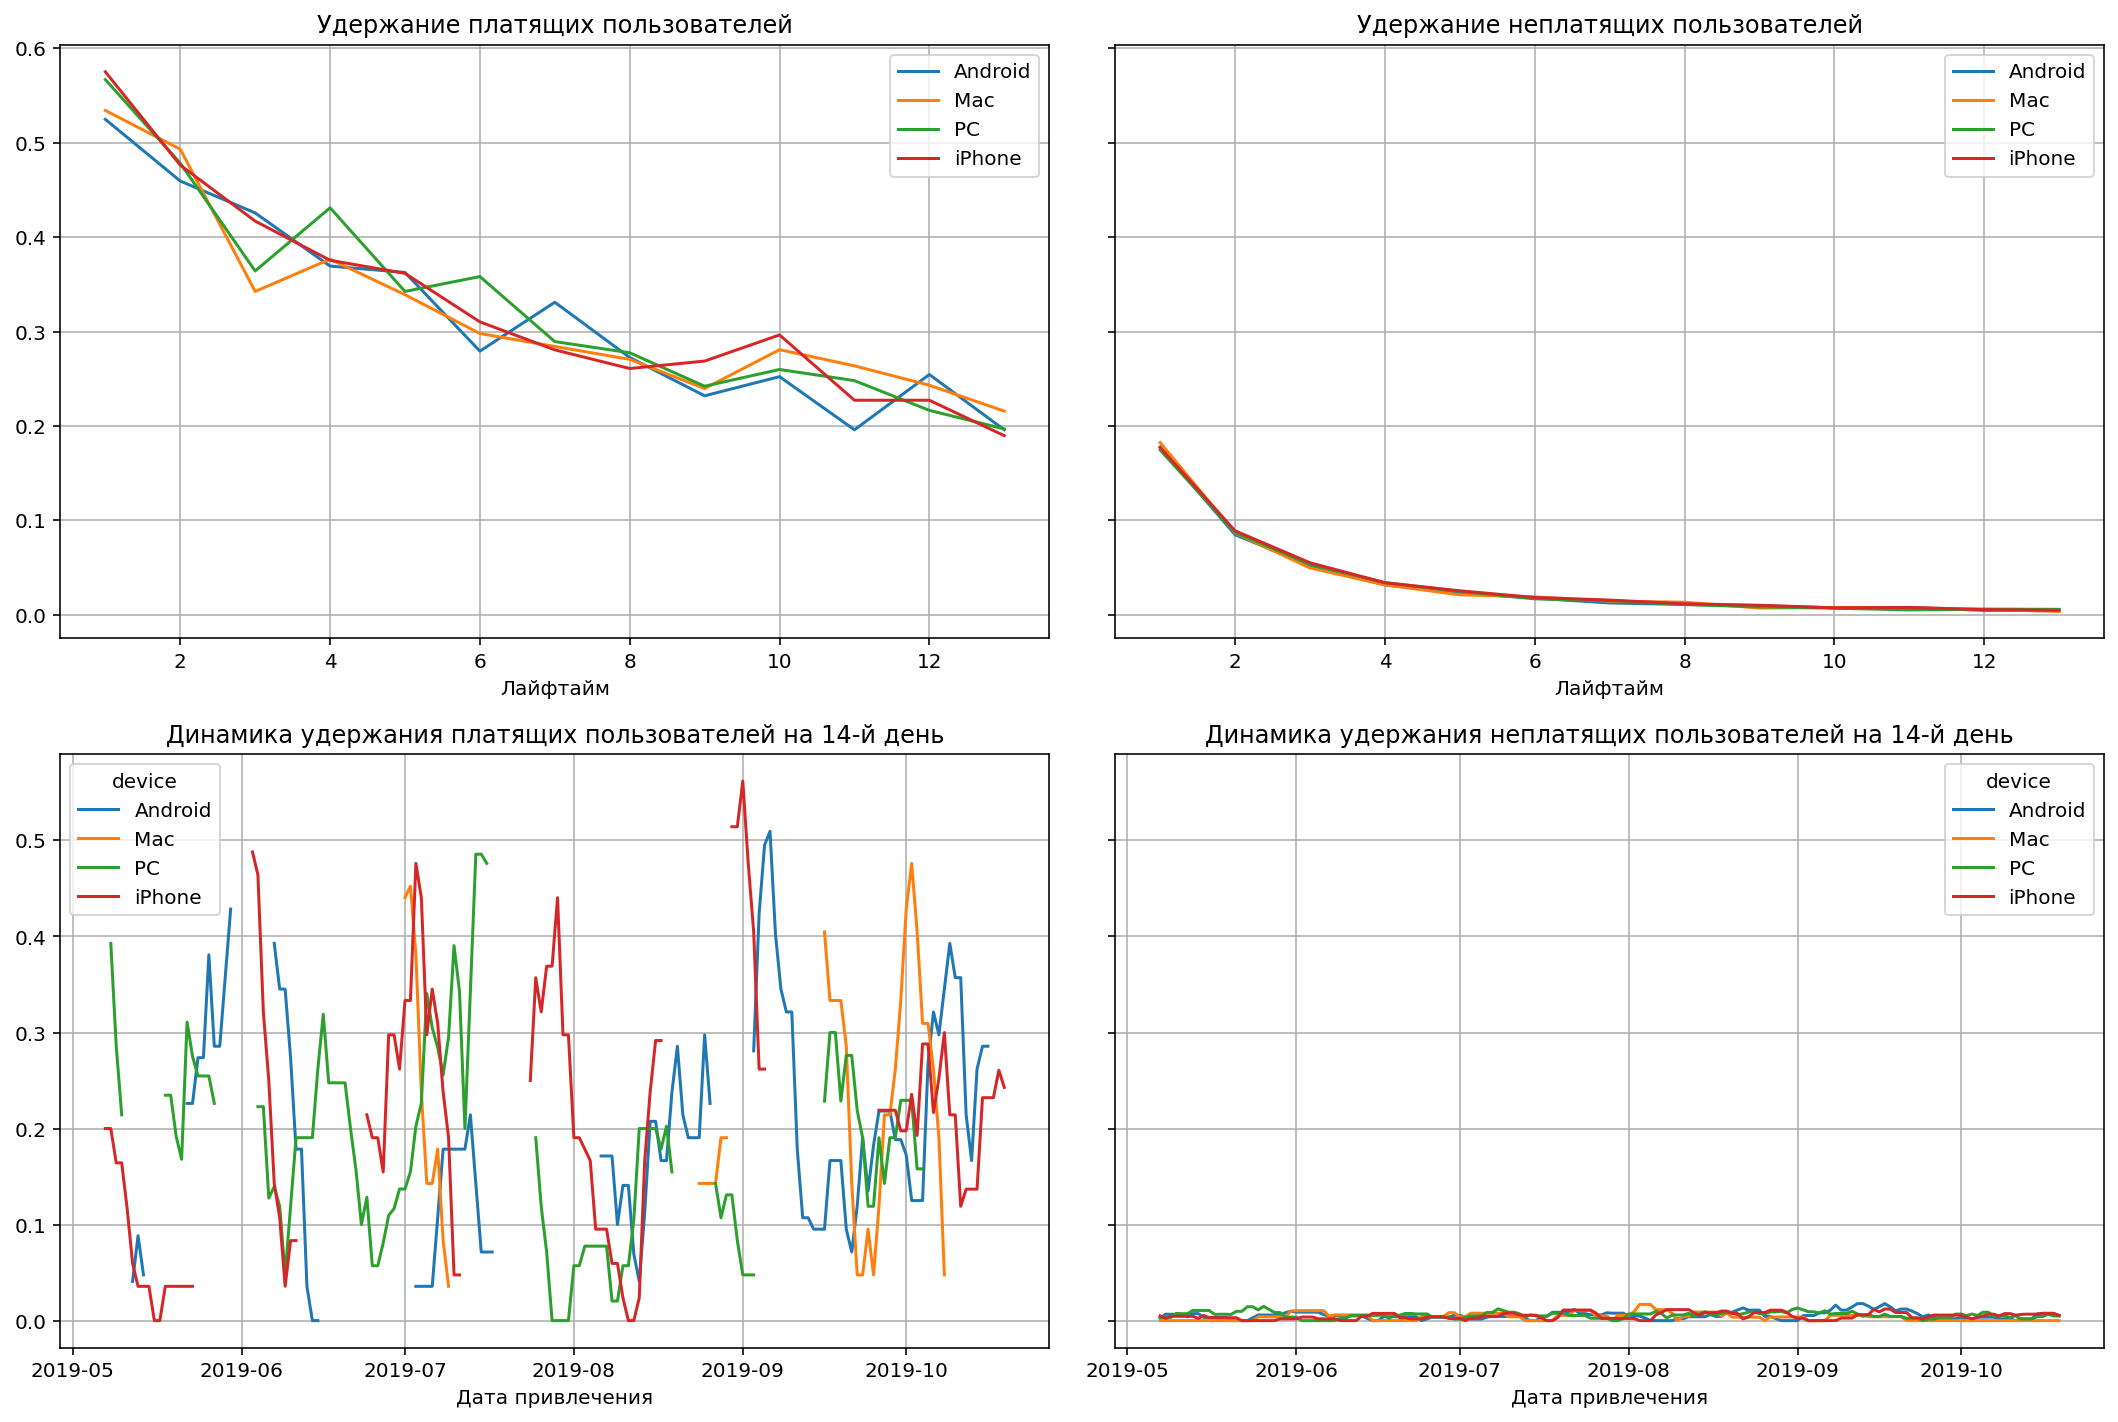

In [47]:
# смотрим удержание с разбивкой по устройствам, без неэффективных каналов

dimensions = ['device']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_paid.query("channel not in @bad_channels"), visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

### **Промежуточный вывод:**

- Больше всего денег (LTV) сейчас приносят пользователи с канала lambdaMediaAds, на втором месте TipTop
- Самый высокий уровень окупаемости (высокий ROI) – у каналов YRabbit, MediaTornado и lambdaMediaAds
- Каналы, которые абсолютно не окупаются (низкий ROI) – AdNonSense, Faceboom и TipTop

## Шаг 6. Общие выводы и рекомендации

### Выделим причины неэффективности привлечения пользователей

Начало рекламной кампании по привлечению трафика из TipTop в США резко ухудшило показатели окупаемости. Эта связка канал-регион показала высокую стоимость привлечения и отрицательую окупаемость. Вероятно, маркетологов мог запутать высокий LTV этого канала. Но, несмотря на то, что канал приносит много денег – они в итоге расходуются на привлечение новых пользователей с постоянно растущей ценой за каждого, что в итоге приводит к убыткам.

Похоже, что причина плохой окупаемости кроется еще и в каналах FaceBoom – регион США, а также AdNonSense в Европе.

В то же время, каналы с высокой окупаемостью и LTV используются маркетингом в меньшей мере, чем могли бы.

### Сформируем рекомендации для отдела маркетинга для повышения эффективности

Инсайты из промежуточных выводов:
- Из США приходит большая доля платящих пользователей, поэтому нельзя исключать регион из продвижения – стоит подобрать канал, который будет иметь стабильный CAC и положительный ROI
- Германия на 2 месте по доле оплат, но имеет низкую долю трафика в приложении, стоит попробовать усилить бюджеты привлечения на этот регион
- Пользователи платформы Mac имеют самый высокий процент оплат, но низкую долю трафика на момент анализа, стоит подобрать связку канал-регион, на которой пользователи данного устройства будут окупаться
- Пользователи, приходящие с бесплатного органического канала привлечения имеют низкую долю оплат – рекомендуется проанализировать поведение этой когорты, чтобы определить точки роста в оплаты, есть потенциал

**Варианты оптимизации:**

- Снизить активность по каналам TipTop и Faceboom в регионе США и распределить бюджеты на другие каналы с высокой эффективностью: YRabbit и MediaTornado
- В европейском регионе снизить активность по каналу AdNonSense, распределив освободившийся бюджет на канал lambdaMediaAds
- Попробовать запустить неэффективные в США каналы TipTop и Faceboom в европейском регионе, а AdNonSense – в США
- Тестировать другие связки канал-регион-устройство на небольших бюджетах, оценивая ROI и следя за стабильностью CAC каждый месяц